## Импортируем библиотеки и загружаем датасеты.

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.integration import OptunaSearchCV

import category_encoders as ce

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV

from sklearn.pipeline import Pipeline, make_pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score,\
                            classification_report, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.feature_selection import GenericUnivariateSelect, chi2, f_classif, mutual_info_classif

pd.set_option('display.max_columns', None)
STATE = 42

In [4]:
df_orders = pd.read_feather('datasets/orders.feather')
df_st = pd.read_feather('datasets/suitable_teachers.feather')
df_ti = pd.read_feather('datasets/teachers_info.feather')
# df_pt = pd.read_feather('datasets/prefered_teachers_order_id.feather')

## Разведочный анализ данных

### Таблица заказов df_orders

Определим неинформативные столбцы и столбцы с большим количеством пропусков и удалим их.

In [5]:
df_orders

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437212,2280503,2022-10-24 19:45:30.277,9.0,Разделы: школьный курс.\nКатегория ученика: ...,1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-10-24 20:17:29.977,205868.0,6,None,NaN,2650,10,2022-11-10 00:00:00.000,NaN,8.0,2,800,2,3,10,4,0,21,30,0,0,23,NaN,824363,NaN,NaN,2650,2022-11-18 00:06:48.273,1
437213,2280504,2022-10-24 19:45:40.713,1.0,Разделы: школьный курс.\nКатегория ученика: ш...,1000,120,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-10-24 20:07:25.370,171067.0,16,None,NaN,0,10,None,983555.0,6.0,2,0,2,0,0,4,0,18,45,0,0,14,2280289.0,362987,13.0,NaN,2700,None,1
437214,2280505,2022-10-24 19:45:44.477,2.0,Разделы: общий курс.\nКатегория ученика: 1 кла...,600,60,None,489.0,Район: Ленинский район.\nМесто проведения заня...,2022-10-24 20:45:51.357,215909.0,16,None,NaN,0,10,None,NaN,2.0,3,500,2,0,0,2,1,21,60,1,0,23,NaN,1019633,17.0,NaN,900,None,1
437215,2280506,2022-10-24 19:46:02.453,18.0,Разделы: математика.\nКатегория ученика: школь...,900,60,None,487.0,Район: Автозаводский район.\nМесто проведения ...,None,NaN,16,None,NaN,0,10,None,372894.0,4.0,4,400,3,0,0,1,0,0,0,0,1,14,2200131.0,791697,8.0,NaN,2565,None,1


In [6]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

Можем избавиться от следующих столбцов:
- ```lesson_place``` - слишком много пропусков
- ```comments``` - комментарии операторов нам не нужны
- ```prefered_teacher_id``` - слишком много пропусков
- ```creator_id``` - идентификатор создателя заявки будет неинформативным признаком
- ```additional_status_id``` - причина закрытия заявки
- ```max_metro_distance``` - слишком много пропусков
- ```payment_date``` - будет неинформативным признаком, т.к. у нас уже есть ключевой столбец со статусом заявки
- ```start_date``` - будет неинформативным признаком, т.к. у нас уже есть ключевой столбец со статусом заявки + тут очень много пропусков в этом столбце
- ```working_teacher_id``` - много пропусков, удаляем
- ```first_lesson_date``` - так же много пропусков, удаляем

In [7]:
cols_to_drop = ['lesson_place', 'comments', 'prefered_teacher_id', 'creator_id', 'additional_status_id',\
                'max_metro_distance', 'payment_date', 'start_date', 'working_teacher_id', 'first_lesson_date']

In [8]:
df_orders = df_orders.drop(cols_to_drop, axis = 1)

Функция для визуализации гистограммы и диаграммы размаха.

In [9]:
def vis(df, col):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout(pad=4.0)

    axs[0].hist(df[col], bins = 15, color = 'skyblue', edgecolor = 'black')
    axs[0].set_title('Гистограмма для {}'.format(col))
    axs[0].set_xlabel('Значения')
    axs[0].set_ylabel('Количество наблюдений')

    sns.boxplot(x = df[col], ax = axs[1], color = 'lightcoral')
    axs[1].set_title('Диаграмма размаха для {}'.format(col))
    axs[1].set_xlabel('Значения')

    plt.show()

#### ИД предмета ```subject_id```

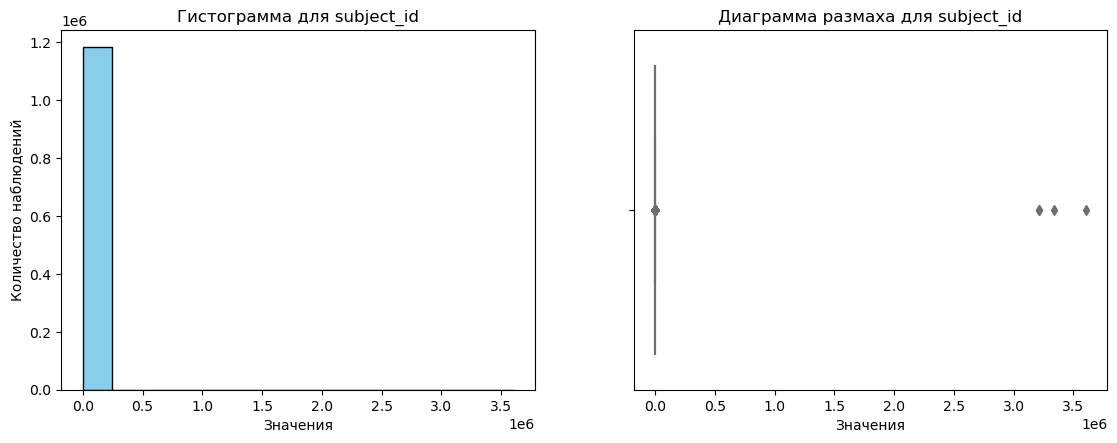

In [10]:
vis(df_orders, 'subject_id')

In [11]:
df_orders['subject_id'].value_counts()

subject_id
8.0          311300
2.0          170795
1.0          109139
18.0          64310
11.0          59778
9.0           58739
10.0          57260
19.0          46735
12.0          42159
14.0          36829
33.0          33361
21.0          24792
13.0          20058
3.0           17530
20.0          16657
7.0           16163
29.0          12630
4.0           12608
27.0          12289
15.0          11372
6.0            8686
16.0           8177
17.0           7860
23.0           7289
36.0           5634
25.0           4912
5.0            4463
3211265.0         2
3342337.0         1
3605505.0         1
Name: count, dtype: int64

В целом, данные в порядке, есть несколько аномальных значений, проверим их.

In [12]:
df_orders[df_orders['subject_id'] > 1000]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,estimated_fee,is_display_to_teachers
105390,3211265,0042-01-12 05:09:05.007,3211265.0,None,3211265,3211265,3211265.0,None,3211265,"8,344264636103745E-308",3211265,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,3211265.0,3211265,"8,344264636103745E-308",1
109392,3342337,0042-01-12 04:26:08.039,3342337.0,None,3342337,3342337,3342337.0,None,3342337,"8,344239172283769E-308",3342337,3342337.0,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,1,1,3342337,3342337.0,3342337,"8,344239172283769E-308",1
79972,3211265,0042-01-12 05:09:05.007,3211265.0,None,3211265,3211265,3211265.0,None,3211265,"8,344264636103745E-308",3211265,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,3211265.0,3211265,"8,344264636103745E-308",1
437216,3605505,0029-07-18 05:28:02.684,3605505.0,None,3605505,3605505,3605505.0,None,3605505,"4,450342944189884E-308",3605505,3605505.0,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,3605505,3605505.0,3605505,"4,450342944189884E-308",1


Судя по всему, это ошибка выгрузки. Удаляем.

In [13]:
df_orders = df_orders[df_orders['subject_id'] < 1000]

#### Цель занятий ```purpose```

In [14]:
df_orders['purpose'].value_counts()

purpose
Разделы:  школьный курс.\nДополнения: ОГЭ (ГИА).\nКатегория ученика: школьник 9 класса.\nЦель занятий: подготовка к ОГЭ.                                                                                                                                                              11450
Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 класс.\nДо экзамена осталось: Несколько месяцев.\n                                                                                                                                                                                       10586
Разделы:  школьный курс.\nДополнения: ЕГЭ.\nКатегория ученика: школьник 11 класса.\nЦель занятий: подготовка к ЕГЭ.                                                                                                                                                                    9765
Цели: помощь по школьной программе.\nКатегория ученика: 8 класс.\n                                                                          

Заполним пропуски значением 'Не указано'. Из этих данных мы можем вытащить разделы и дополнения, и добавить их как новые признаки.

In [15]:
df_orders['purpose'].fillna('Не указано', inplace = True)

In [16]:
df_orders['purpose']

0                                                Не указано
1                                                Не указано
2         Разделы: начертательная геометрия.\nКатегория ...
3         Разделы:  школьный курс.\nКатегория ученика: ш...
4                                                Не указано
                                ...                        
437211    Дополнения: ОГЭ (ГИА), подготовка к олимпиадам...
437212    Разделы:  школьный курс.\nКатегория ученика:  ...
437213    Разделы:  школьный курс.\nКатегория ученика: ш...
437214    Разделы: общий курс.\nКатегория ученика: 1 кла...
437215    Разделы: математика.\nКатегория ученика: школь...
Name: purpose, Length: 1181525, dtype: object

#### Стоимость занятия ```lesson_price```

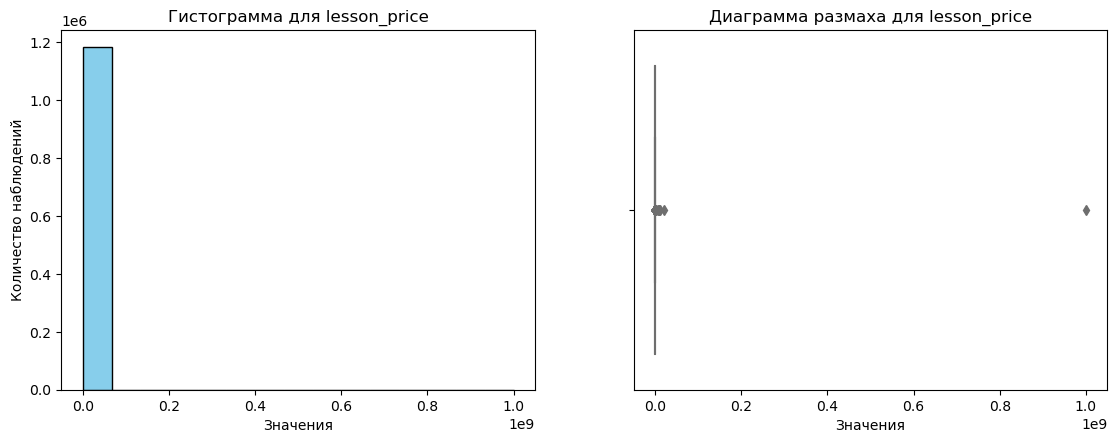

In [17]:
vis(df_orders, 'lesson_price')

Графики неинформативны из-за наличия выбросов.

In [18]:
df_orders['lesson_price'].max()

1000000000

In [19]:
df_orders['lesson_price'].nlargest(50)

21341     1000000000
81022       20000000
94824       10090000
363192      10000000
292373       7777777
91858        7500095
93749        1000000
203592        800000
69295         700000
220749        600000
221147        600000
222577        600000
13210         500000
138672        500000
138755        500000
83702         200000
83856         200000
84031         200000
67933         180000
68591         180000
68592         180000
68643         180000
68675         180000
91443         160000
112999        150000
125820        150000
235162        138000
235985        138000
236886        138000
16404         120000
5390          120000
167363        120000
174853        120000
138092        120000
138863        120000
139336        120000
142097        120000
142099        120000
143630        120000
149075        120000
149079        120000
150039        120000
150633        120000
39520         100000
43263         100000
4420          100000
6946          100000
46241        

Не совсем понятно, в каком формате указаны данные. Если за 1 урок, то это, очевидно, выбросы, если за несколько, тогда это адекватные значения.

Пока что удалим очевидные аномалии свыше 1кк.

In [20]:
df_orders = df_orders[df_orders['lesson_price'] < 1000000]

#### Продолжительность урока ```lesson_duration```

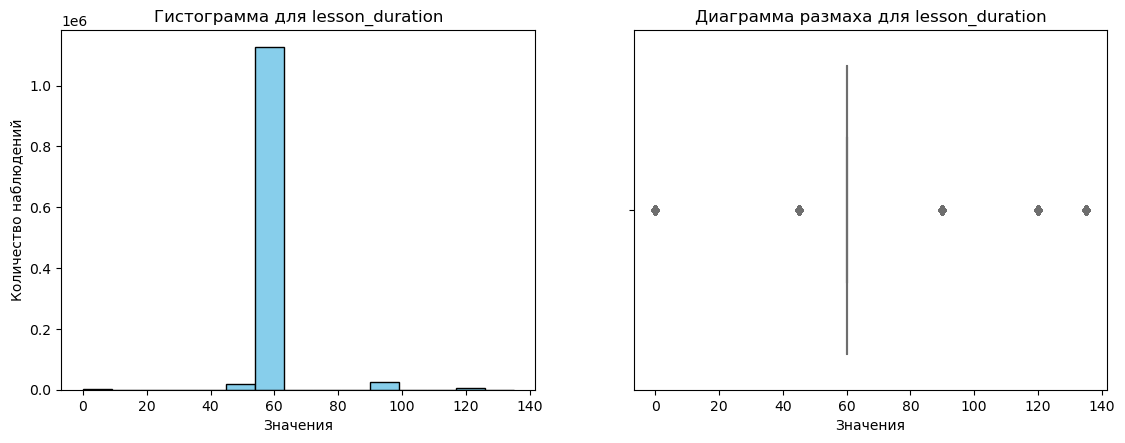

In [21]:
vis(df_orders, 'lesson_duration')

In [22]:
df_orders['lesson_duration'].value_counts()

lesson_duration
60     1126177
90       25638
45       19914
120       7211
0         2386
135        192
Name: count, dtype: int64

Тут со значениями всё в порядке. Нулевую продолжительность так же оставляем, она будет означать, что продолжительность не указана в заявке.

### ИД метро ```home_metro_id```

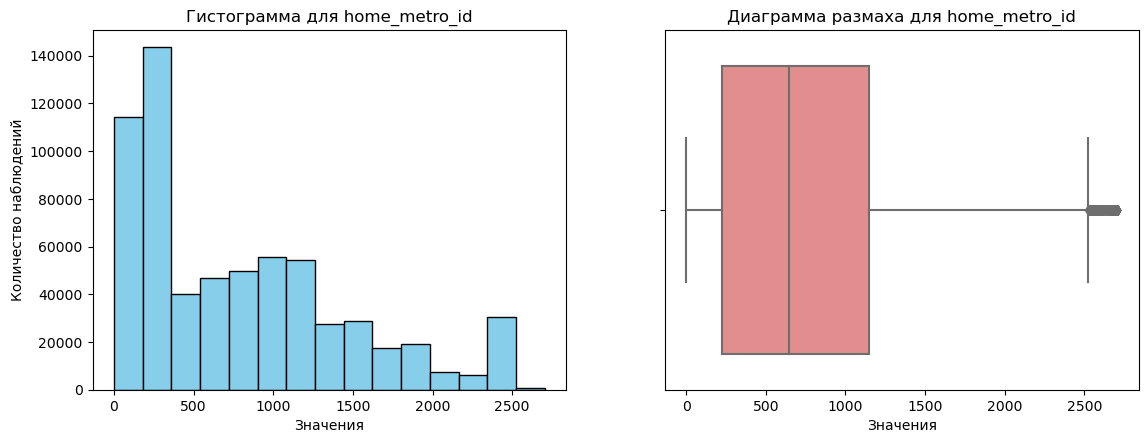

539264

In [23]:
vis(df_orders, 'home_metro_id')
df_orders['home_metro_id'].isna().sum()

Присутствует большое количество пропусков, но так же есть и нулевые значения. Заменим пропуски на нули, будем считать, что это равно значению «не указано».

In [24]:
df_orders['home_metro_id'] = df_orders['home_metro_id'].fillna(0)

#### Дополнительная информация ```add_info```

In [25]:
df_orders['add_info']

0                                                      None
1                                                      None
2         Место проведения занятий: дистанционно (наприм...
3         Место проведения занятий: дистанционно (наприм...
4                                                      None
                                ...                        
437211                                                 None
437212    Место проведения занятий: дистанционно (наприм...
437213    Место проведения занятий: дистанционно (наприм...
437214    Район: Ленинский район.\nМесто проведения заня...
437215    Район: Автозаводский район.\nМесто проведения ...
Name: add_info, Length: 1181518, dtype: object

In [26]:
df_orders['add_info'].fillna('Не указано', inplace = True)

Можем вытащить место проведения занятий и район.

In [27]:
df_orders['add_info'].value_counts()

add_info
Не указано                                                                                                                                                                                                                                                                                                                                                 140662
Количество занятий в неделю: 1-2.\nВозраст репетитора: не важно.\nПол репетитора: Не важно.\n                                                                                                                                                                                                                                                                7234
Подстроюсь под репетитора                                                                                                                                                                                                                                                                  

#### Статус заказа ```status_id```

Это наш целевой признак, нам важны статусы **5, 6, 13, 15** - эти заявки можно считать оплаченными.

Преобразуем значения в столбце.

In [28]:
df_orders['status_id'] = df_orders['status_id'].apply(lambda x: 1 if x in [5, 6, 13, 15] else 0)

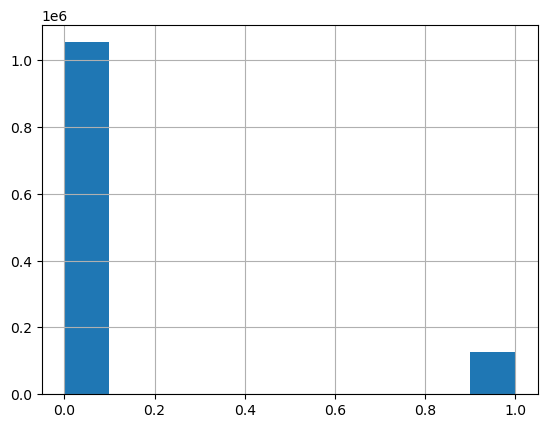

In [29]:
df_orders['status_id'].hist();

In [30]:
df_orders['status_id'].value_counts()

status_id
0    1054128
1     127390
Name: count, dtype: int64

Явный дисбаланс классов в сторону неоплаченных заявок.

#### Сумма к оплате ```amount_to_pay```

Столбец имеет тип object, приведем его к типу float и проверим значения.

In [31]:
df_orders['amount_to_pay'] = df_orders['amount_to_pay'].str.replace(',', '.').astype(float)

In [32]:
df_orders['amount_to_pay'].value_counts()

amount_to_pay
0.0       1027757
250.0        5427
1500.0       4689
750.0        4625
375.0        4072
           ...   
7360.0          1
2394.0          1
1316.0          1
4987.5          1
9500.0          1
Name: count, Length: 1412, dtype: int64

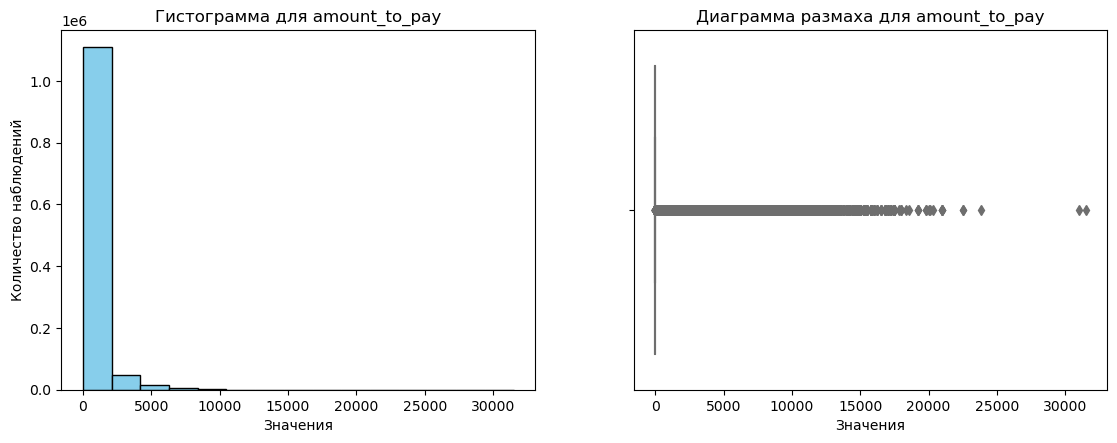

In [33]:
vis(df_orders, 'amount_to_pay')

In [34]:
df_orders['amount_to_pay'].nlargest(10)

6496      31500.0
100857    31000.0
231853    23850.0
26049     22500.0
76467     22500.0
187282    21000.0
257552    21000.0
218758    21000.0
301561    21000.0
320146    20300.0
Name: amount_to_pay, dtype: float64

In [35]:
df_orders[df_orders['amount_to_pay'] > 20000]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,estimated_fee,is_display_to_teachers
79940,1823305,2021-10-15 17:26:30.180,8.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,6000,120,24.0,Район: м. Войковская.\nМесто проведения заняти...,1,20100.0,10,11.0,2,2500,3,5,0,6,0,0,0,0,0,16,NaN,859300,20100,1
100857,2579476,2023-04-22 11:47:14.943,8.0,Два ученика 1 и 3 классы.\nРазделы: школьный ...,5000,60,2474.0,Район: м. Мичуринский проспект.\nМесто проведе...,1,31000.0,10,4.0,5,2500,3,0,0,1,0,25,0,0,0,14,2579262.0,560161,15500,1
26049,2614060,2023-05-25 18:14:45.857,10.0,"Цели: подготовить к экзамену.\nРазделы: C, ass...",5000,60,139.0,Как далеко могу ехать к репетитору: 20000.\nЖе...,1,22500.0,10,14.0,5,0,0,0,0,6,0,0,0,0,0,23,NaN,1149475,15000,1
76467,2664478,2023-07-10 16:14:17.963,9.0,Разделы: квантовая механика.\nКатегория ученик...,5000,60,0.0,Место проведения занятий: дистанционно (наприм...,1,22500.0,10,14.0,4,0,1,0,0,4,0,0,0,0,0,23,NaN,1168841,15000,1
187282,2775293,2023-09-08 13:41:17.703,10.0,"Дополнения: ЕГЭ, подготовка к олимпиадам.\nКат...",5000,60,0.0,Место проведения занятий: дистанционно (наприм...,1,21000.0,10,12.0,3,0,1,0,0,4,0,0,0,0,0,23,2773067.0,1208715,17500,0
257552,2845563,2023-09-30 13:45:55.940,29.0,"Разделы: развитие речи, раннее развитие.\nКате...",5000,60,231.0,Район: г. Одинцово.\nМесто проведения занятий:...,1,21000.0,10,17.0,5,0,3,0,0,1,0,0,0,0,0,23,NaN,1235493,15000,0
6496,1848062,2021-11-08 15:36:41.337,21.0,Разделы: архитектура.\nКатегория ученика: взро...,10000,120,22.0,Район: м. Водный стадион.\nМесто проведения за...,1,31500.0,10,15.0,4,5000,3,0,0,1,0,28,0,0,0,16,NaN,867293,15000,1
218758,2060352,2022-05-18 10:17:04.493,8.0,Разделы: школьный курс.\nДополнения: подготов...,6000,120,112.0,Район: м. Полежаевская.\nМесто проведения заня...,1,21000.0,10,9.0,6,0,3,0,0,1,0,0,0,1,0,4,NaN,345516,21000,1
231853,2075095,2022-06-02 18:16:18.297,21.0,Разделы: сурдопедагогика.\nКатегория ученика: ...,15000,0,2471.0,Район: м. Верхние Лихоборы.\nМесто проведения ...,1,23850.0,10,3.0,7,3000,3,0,0,1,0,0,0,0,0,8,NaN,947432,39750,1
301561,2144807,2022-08-23 19:32:43.780,2.0,Разделы: общий курс.\nКатегория ученика: мужчи...,4500,60,78.0,Район: м. Новослободская.\nМесто проведения за...,1,21000.0,10,15.0,6,0,3,10,0,6,2,0,60,0,0,23,NaN,974438,15750,1


Присутствуют выбросные значения, однако эти заявки в статусе оплачено, поэтому оставляем эти значения

#### Запланированное количетво занятий ```planned_lesson_number```

In [36]:
df_orders['planned_lesson_number'].value_counts()

planned_lesson_number
10    938592
0     156471
7      68318
2      11594
1       6543
Name: count, dtype: int64

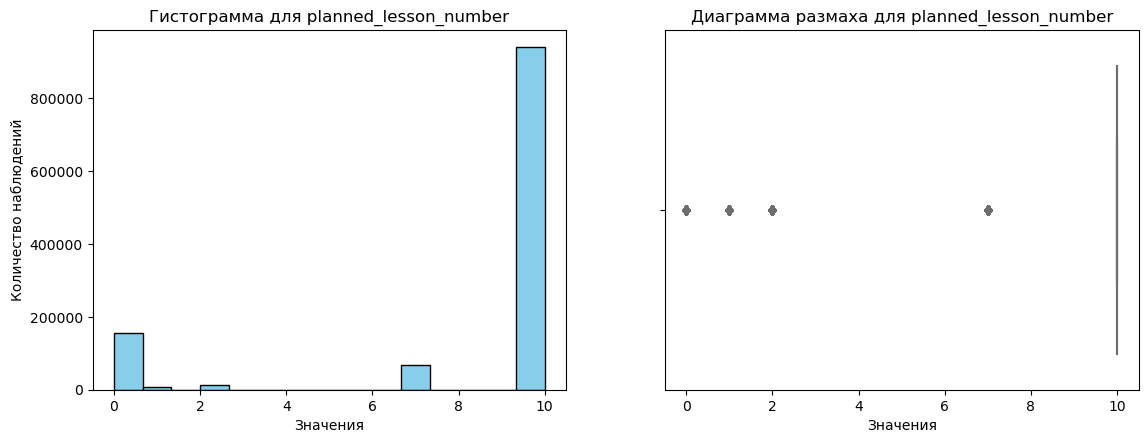

In [37]:
vis(df_orders, 'planned_lesson_number')

Значения адекватные, оставляем все.

#### Возраст ученика ```pupil_category_new_id```

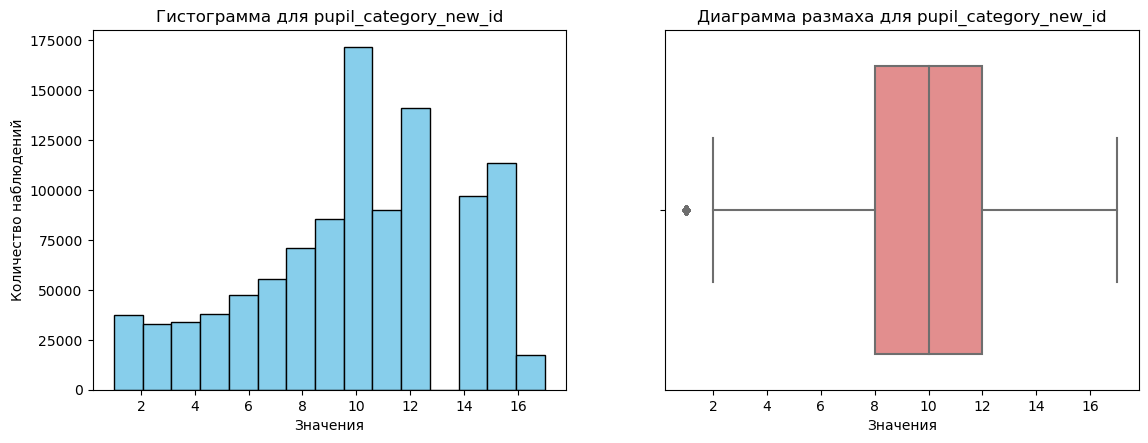

In [38]:
vis(df_orders, 'pupil_category_new_id')

In [39]:
df_orders['pupil_category_new_id'].value_counts()

pupil_category_new_id
10.0    171490
12.0    140959
15.0    113657
14.0     97068
11.0     90124
9.0      85326
8.0      71199
7.0      55470
6.0      47306
5.0      38143
4.0      33694
3.0      32661
1.0      19149
2.0      18275
16.0     12340
17.0      5071
Name: count, dtype: int64

Значения адекватные. Скорее всего, это не возраст учеников, а идентификаторы возрастных категорий, где каждому значению соответствует определённый возрастной диапазон.

Заполним пропущенные значения нулями.

In [40]:
df_orders['pupil_category_new_id'] = df_orders['pupil_category_new_id'].fillna(0)

#### Число занятий в неделю ```lessons_per_week```

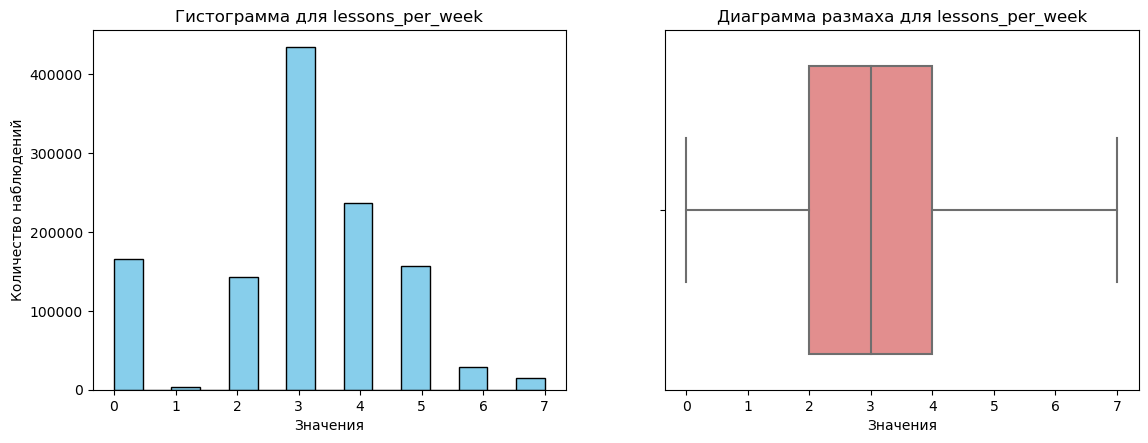

In [41]:
vis(df_orders, 'lessons_per_week')

In [42]:
df_orders['lessons_per_week'].value_counts()

lessons_per_week
3    433812
4    236427
0    165238
5    156420
2    142470
6     28211
7     15079
1      3861
Name: count, dtype: int64

Адекватные значения, идём дальше.

#### Минимальная цена ```minimal_price```

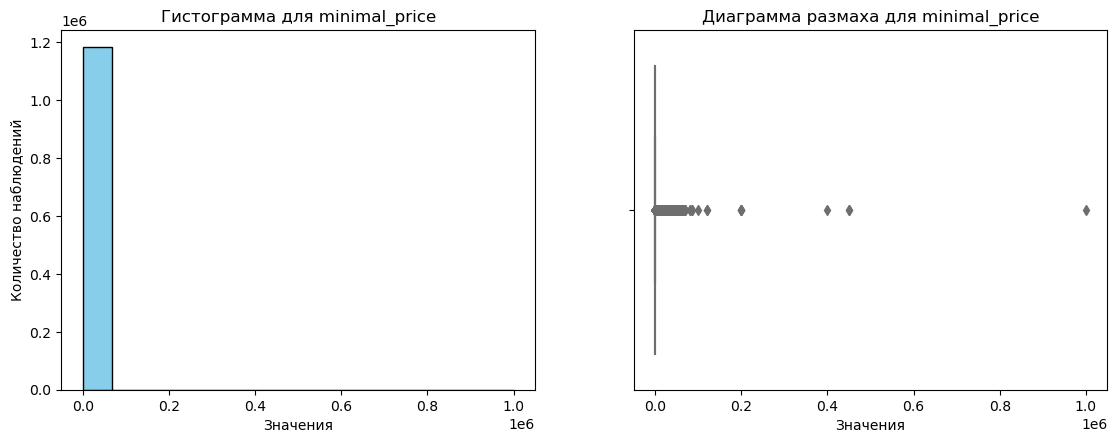

In [43]:
vis(df_orders, 'minimal_price')

In [44]:
df_orders['minimal_price'].value_counts()

minimal_price
0       886973
500      95068
1000     70851
400      28103
700      23929
         ...  
1850         1
442          1
124          1
590          1
295          1
Name: count, Length: 166, dtype: int64

In [45]:
df_orders['minimal_price'].nlargest(20)

183112    1000000
47071      450000
49347      450000
69295      400000
138672     200000
138755     200000
218716     200000
232357     200000
112999     120000
125820     120000
16404      100000
421006      85000
424556      85000
5390        80000
17693       80000
83229       70000
84012       70000
26570       70000
68585       68000
129734      65000
Name: minimal_price, dtype: int32

In [46]:
df_orders[df_orders['minimal_price'] > 20000]['status_id'].value_counts()

status_id
0    200
1      4
Name: count, dtype: int64

Присутствуют выбросы, большая часть из которых относится к неоплаченным заявкам. Их можно удалить.

In [47]:
df_orders = df_orders[df_orders['minimal_price'] < 20000]

#### Пол учителя ```teacher_sex```

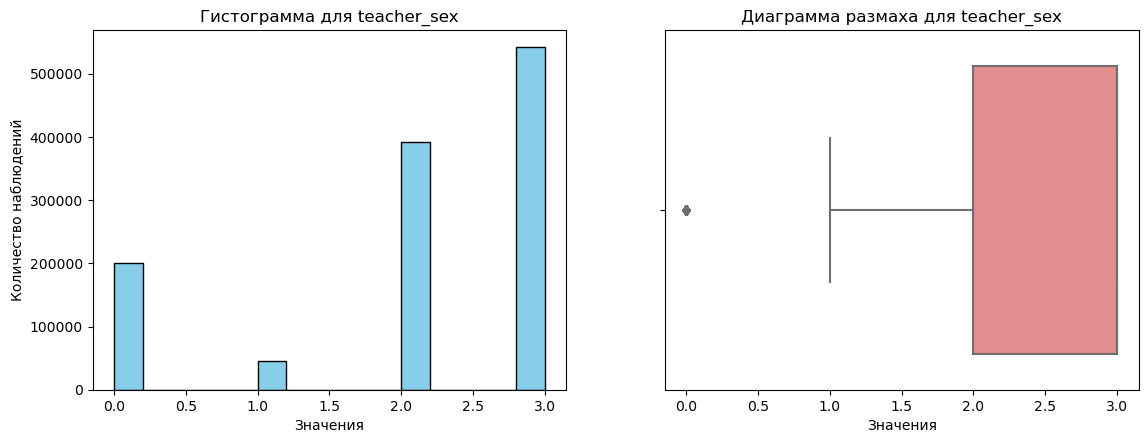

In [48]:
vis(df_orders, 'teacher_sex')

Значения 1 и 2 - пол преподавателя указан.
3 - пол не имеет значения, 0 - значение не указано. Можем объёдинить 0 и 3, чтобы получить 3 категории.

In [49]:
df_orders['teacher_sex'] = df_orders['teacher_sex'].astype(str).replace('0', '3').astype(int)

In [50]:
df_orders['teacher_sex'].value_counts()

teacher_sex
3    743076
2    392172
1     46039
Name: count, dtype: int64

#### Желаемый опыт от ```teacher_experience_from```

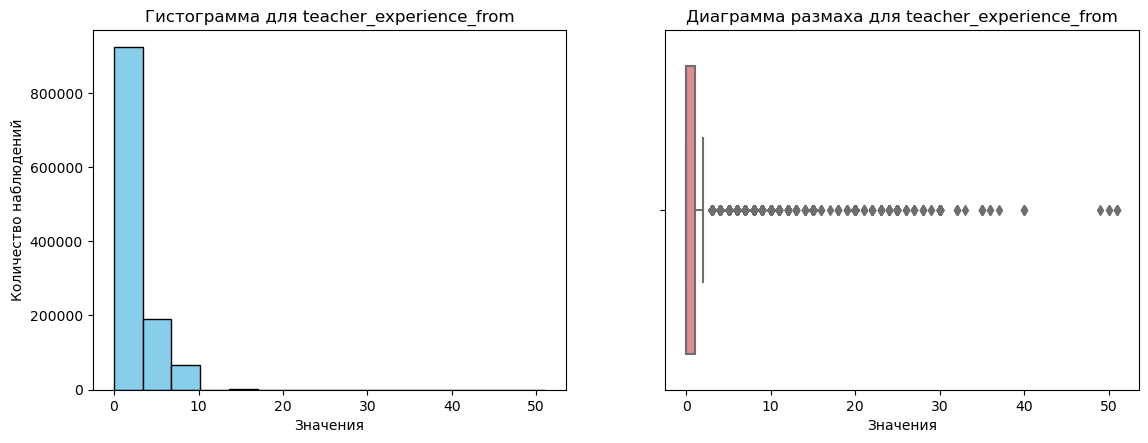

In [51]:
vis(df_orders, 'teacher_experience_from')

In [52]:
df_orders['teacher_experience_from'].value_counts()

teacher_experience_from
0     834819
5     183807
1      61320
10     60816
2      13685
3      13046
4       5336
7       5038
6       1155
8        884
15       673
20       368
9         64
30        63
25        54
12        33
11        25
13        15
24        11
23         9
22         8
14         6
18         6
28         5
19         4
26         4
35         4
27         4
51         3
32         3
16         3
21         3
40         3
50         2
29         2
36         2
33         1
49         1
17         1
37         1
Name: count, dtype: int64

#### Желаемый опыт до ```teacher_experience_to```

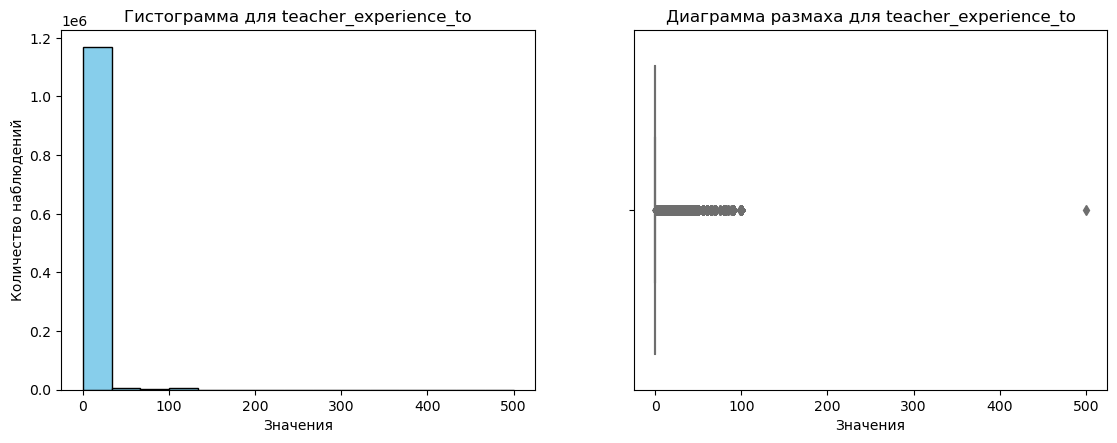

In [53]:
vis(df_orders, 'teacher_experience_to')

In [54]:
df_orders['teacher_experience_to'].value_counts()

teacher_experience_to
0      1164241
100       4898
50        3291
10        1931
60        1457
        ...   
14           1
99           1
26           1
9            1
500          1
Name: count, Length: 65, dtype: int64

Заменим выбросные значения на нулевые.

In [55]:
df_orders.loc[df_orders['teacher_experience_to'] > 90, 'teacher_experience_to'] = 0

#### Формат занятий ```lesson_place_new```

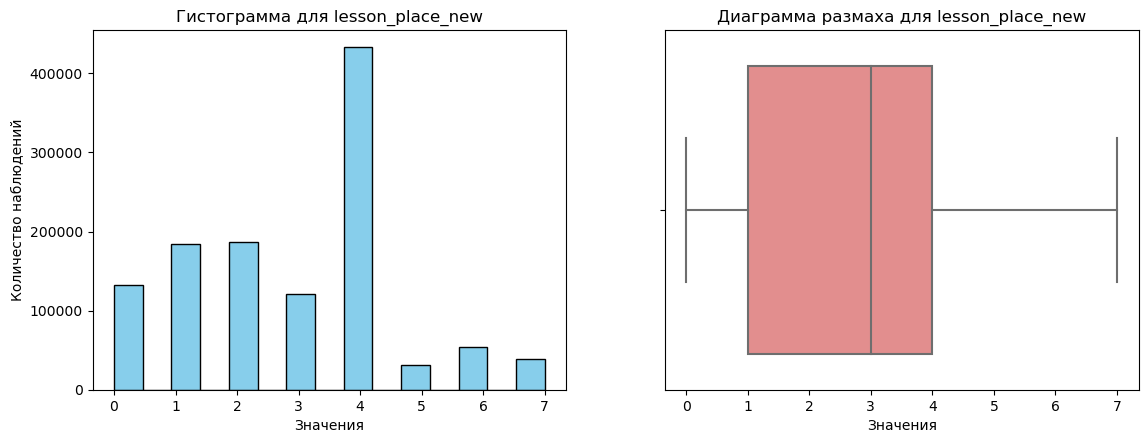

In [56]:
vis(df_orders, 'lesson_place_new')

In [57]:
df_orders['lesson_place_new'].value_counts()

lesson_place_new
4    433153
2    186246
1    184735
0    132176
3    120771
6     53710
7     38729
5     31767
Name: count, dtype: int64

Адекватные значения, обозначения категорий не важны.

#### Уровень знаний ученика ```pupil_knowledgelvl```

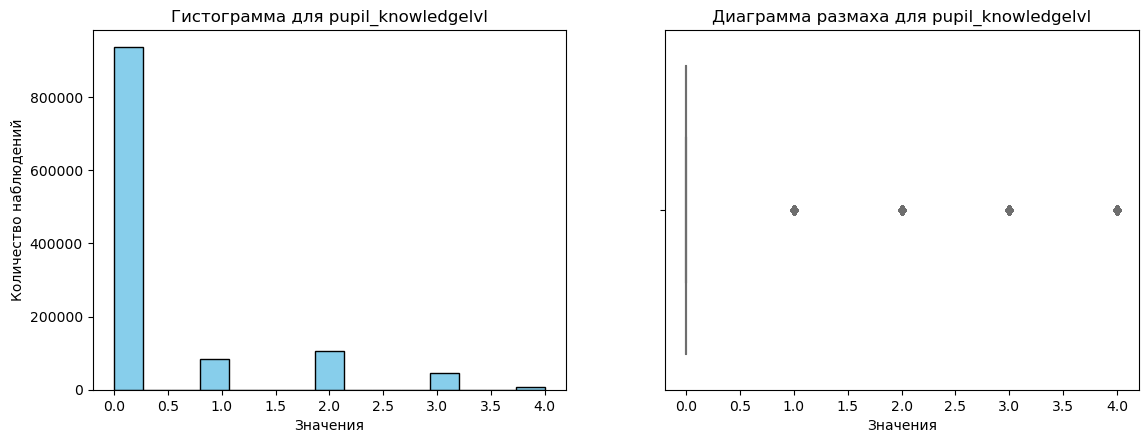

In [58]:
vis(df_orders, 'pupil_knowledgelvl')

In [59]:
df_orders['pupil_knowledgelvl'].value_counts()

pupil_knowledgelvl
0    936881
2    105444
1     85382
3     46852
4      6728
Name: count, dtype: int64

Данные адекватные.

#### Желаемый возраст репетитора от/до ```teacher_age_from/to```

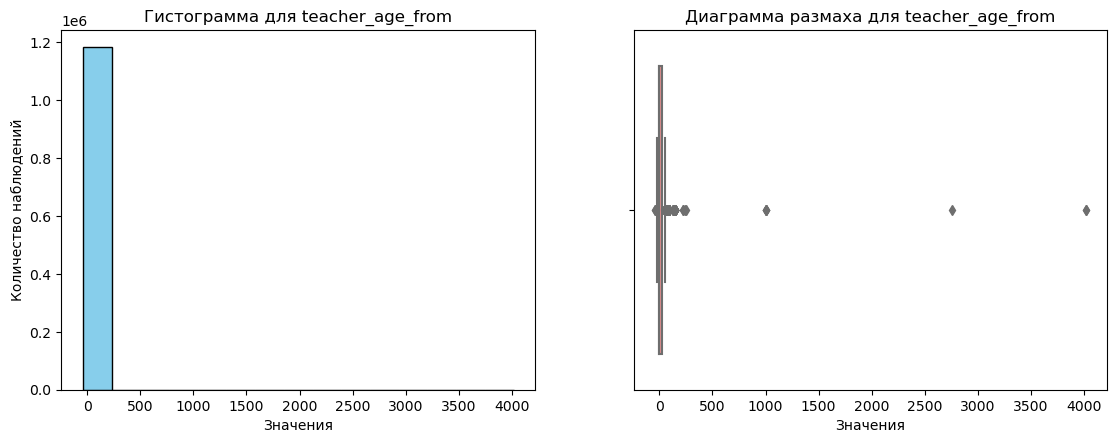

teacher_age_from
0      766943
25     155184
16      60213
30      50946
18      44439
        ...  
59          1
220         1
222         1
75          1
72          1
Name: count, Length: 83, dtype: int64

In [60]:
vis(df_orders, 'teacher_age_from')
df_orders['teacher_age_from'].value_counts()

Заменим выбросные значения на 0.

In [61]:
df_orders.loc[df_orders['teacher_age_from'] > 90, 'teacher_age_from'] = 0

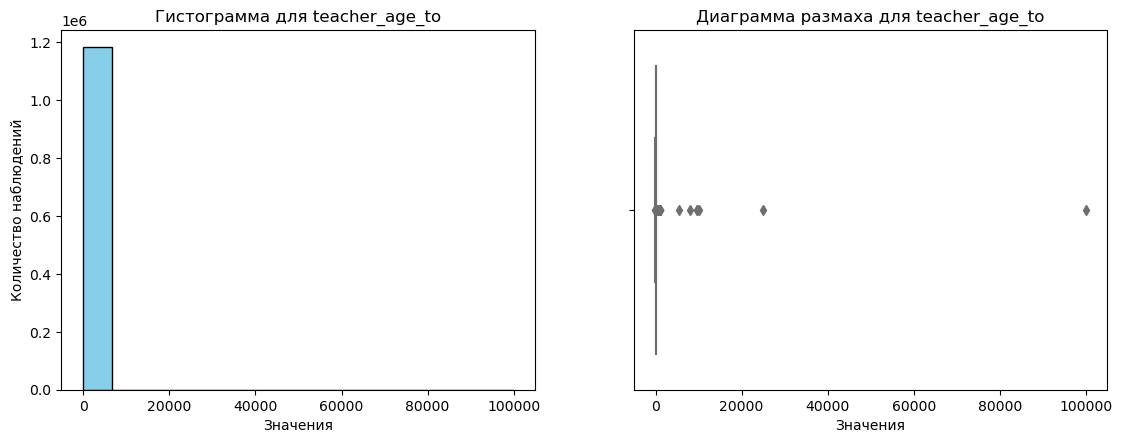

teacher_age_to
 0        816554
 50       137830
 90        43654
 80        40198
 30        21492
           ...  
 8000          1
 10            1
 180           1
 25000         1
-65            1
Name: count, Length: 106, dtype: int64

In [62]:
vis(df_orders, 'teacher_age_to')
df_orders['teacher_age_to'].value_counts()

Заменим выбросы и аномалии на 0.

In [63]:
df_orders.loc[(df_orders['teacher_age_to'] > 90) | (df_orders['teacher_age_to'] < 14), 'teacher_age_to'] = 0

#### Не предлагать репетиторов, кроме выбранных самостоятельно ```chosen_teachers_only```

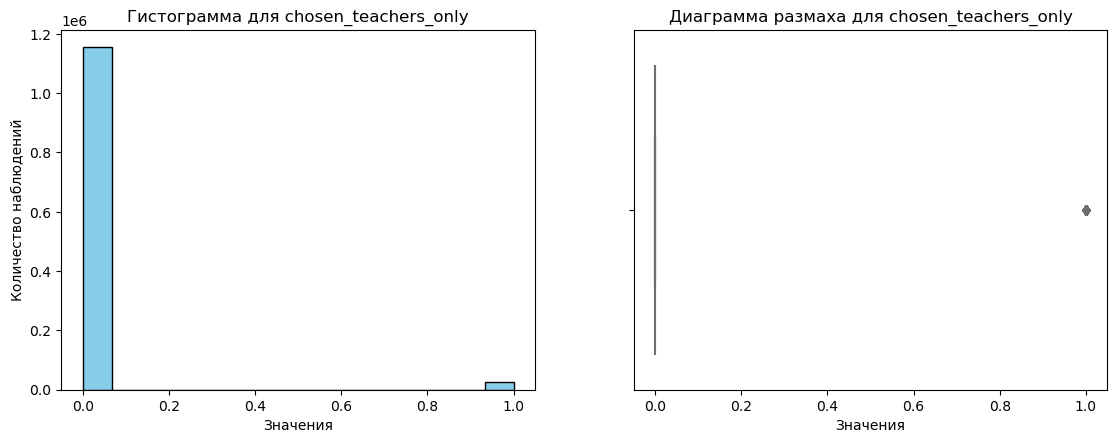

In [64]:
vis(df_orders, 'chosen_teachers_only')

Значения адекватные.

#### На заявку нет подходящий репетиторов ```no_teachers_available```

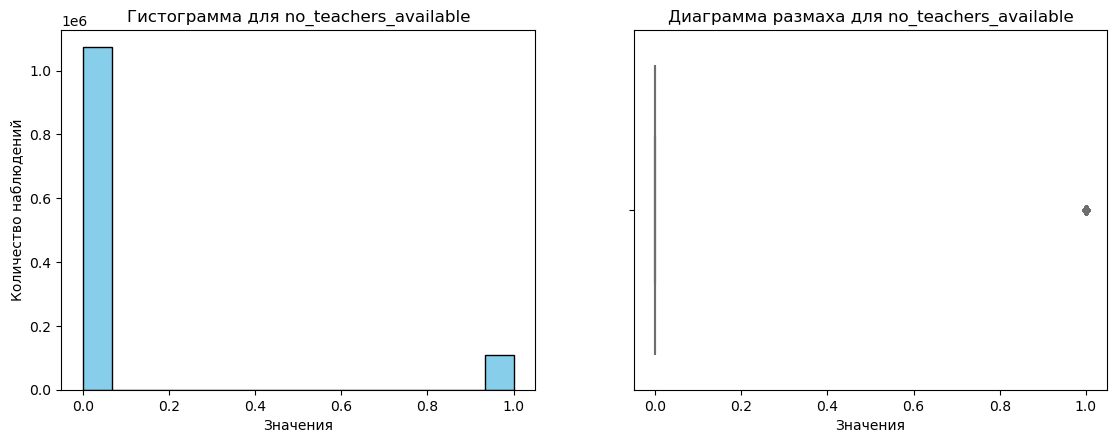

In [65]:
vis(df_orders, 'no_teachers_available')

Адекватные значения, оставляем.

#### В какой части сайта создана заявка ```source_id```

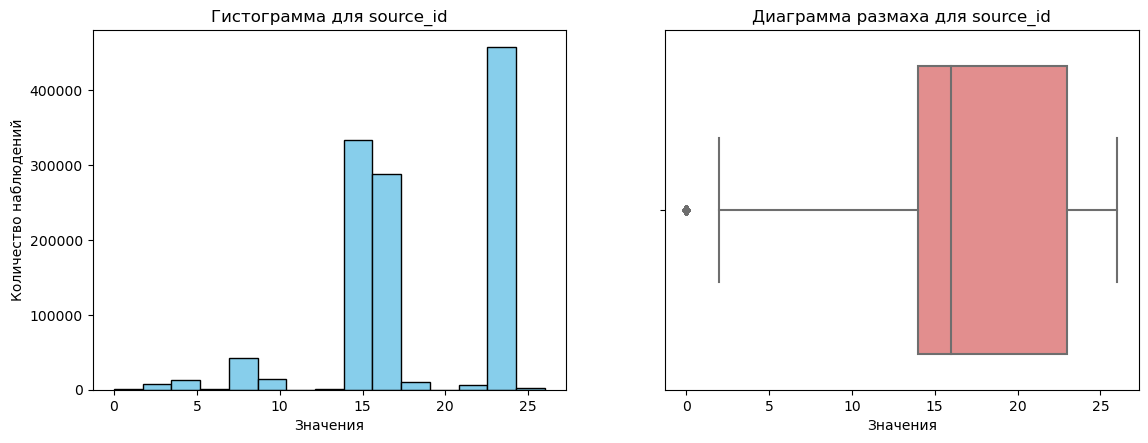

In [66]:
vis(df_orders, 'source_id')

In [67]:
df_orders['source_id'].value_counts()

source_id
23    442103
14    334291
16    279678
8      42169
24     15749
9      14599
18     10033
4       9813
17      8906
2       7851
22      6559
5       3614
25      2321
6       1020
13       808
7        727
0        527
12       274
3        180
26        38
11        17
20        10
Name: count, dtype: int64

Значения адекватные.

#### Дублем какой заявки является ```original_order_id```

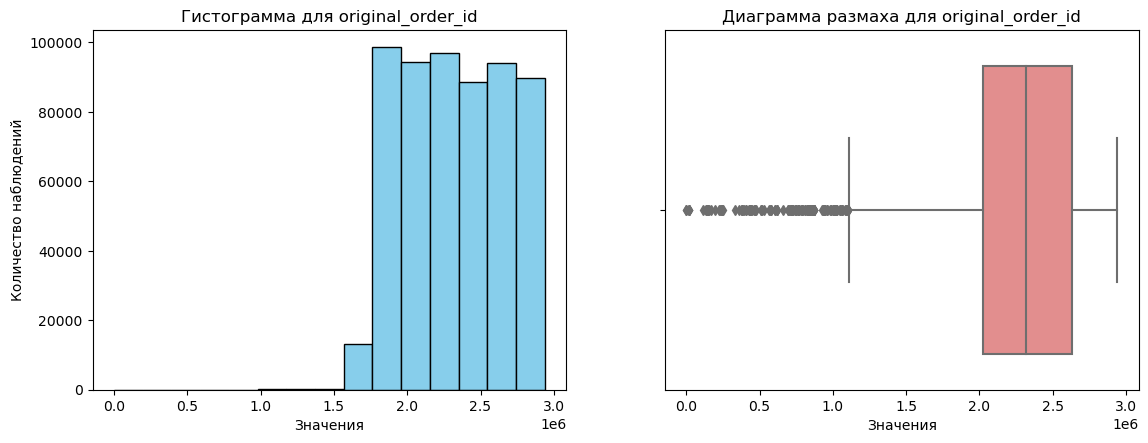

In [68]:
vis(df_orders, 'original_order_id')

In [69]:
df_orders['original_order_id'].value_counts()

original_order_id
1751638.0    100
2289774.0     92
2353479.0     87
2509516.0     83
2075564.0     79
            ... 
2682551.0      1
2680462.0      1
2682528.0      1
2683012.0      1
2243958.0      1
Name: count, Length: 312027, dtype: int64

Этот столбец мы будем использовать в следующем шаге для обработки дублей.

#### Идентификатор клиента ```client_id```

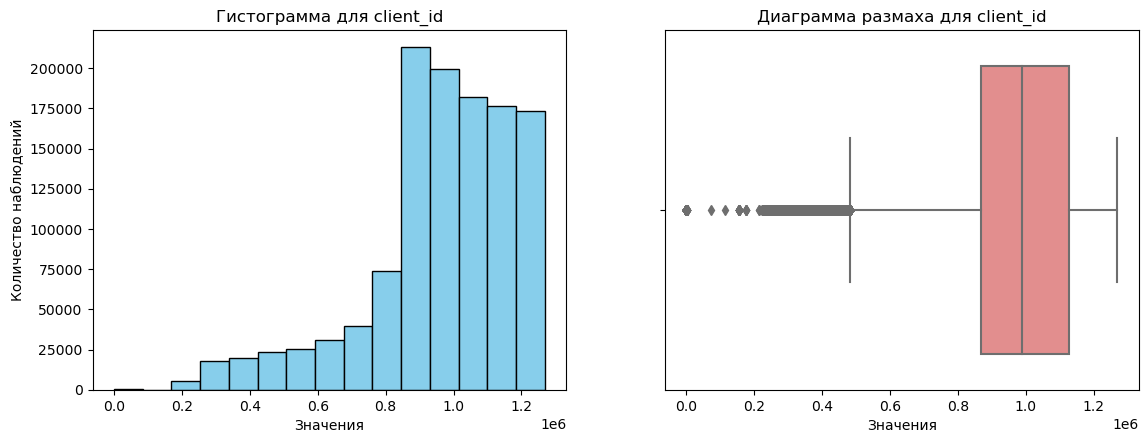

In [70]:
vis(df_orders, 'client_id')

#### Хочет ли клиент получать отклики от репетиторов ```is_display_to_teachers```

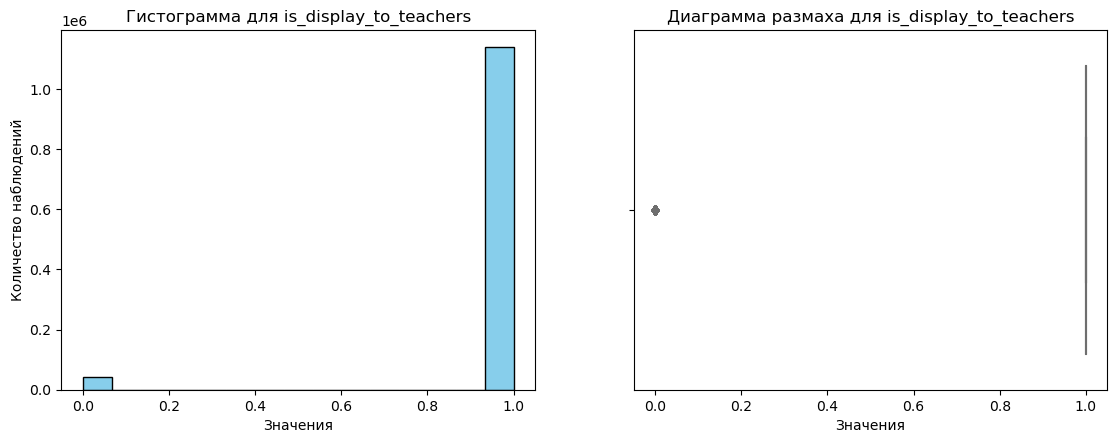

In [71]:
vis(df_orders, 'is_display_to_teachers')

Адекватные значения, оставляем.

#### ```'estimated_fee'```

Заполним нулями, приведём к нужному типу и проверим.

In [72]:
df_orders['estimated_fee']= df_orders['estimated_fee'].fillna('0')
df_orders['estimated_fee']= df_orders['estimated_fee'].str.replace(',', '.').astype(float)

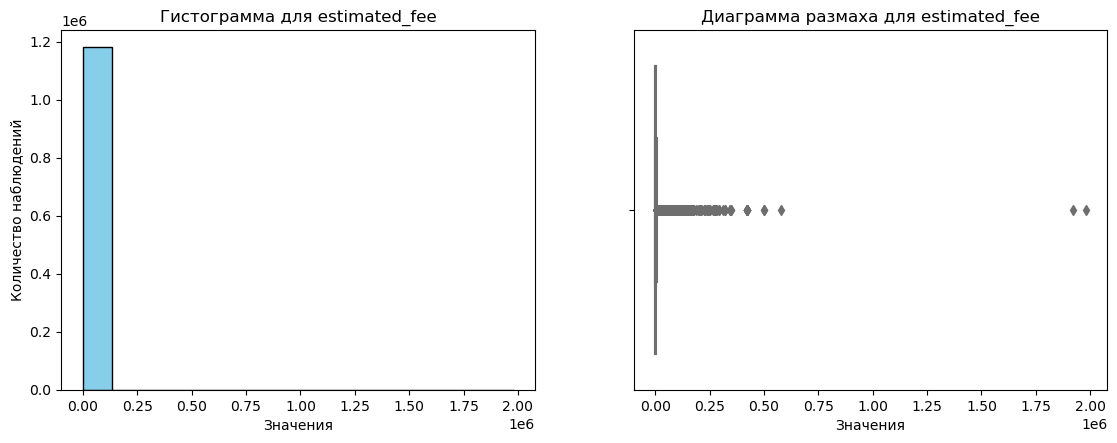

In [73]:
vis(df_orders, 'estimated_fee')

In [74]:
df_orders['estimated_fee'].value_counts()

estimated_fee
0.0         492073
5250.0       23986
2250.0       22982
1500.0       19218
1350.0       13611
             ...  
40500.0          1
11970.0          1
110000.0         1
129000.0         1
4785.0           1
Name: count, Length: 1560, dtype: int64

#### Дата заказа ```order_date```

Приведём столбец к типу date_time.

In [75]:
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'])

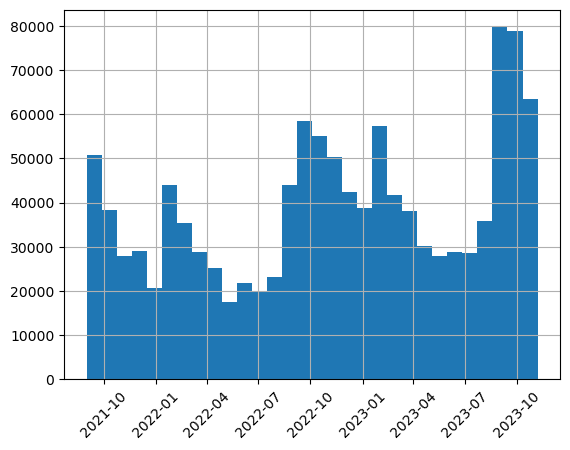

In [76]:
df_orders['order_date'].hist(bins = 30)
plt.xticks(rotation = 45);

В целом, видна некоторая сезонность в распределении количества заявок за разные временные периоды. Это говорит о значимости данного признака. На следующем этапе сформируем из него дополнительные временные признаки.

## Промежуточный вывод

Были удалены неинформативные столбцы:
- ```id``` - идентификатор
- ```lesson_place``` - слишком много пропусков
- ```comments``` - комментарии операторов нам не нужны
- ```prefered_teacher_id``` - слишком много пропусков
- ```creator_id``` - идентификатор создателя заявки будет неинформативным признаком
- ```additional_status_id``` - не совсем понятно, что это за данные
- ```max_metro_distance``` - слишком много пропусков
- ```estimated_fee``` - слишком много пропусков
- ```payment_date``` - будет неинформативным признаком, т.к. у нас уже есть ключевой столбец со статусом заявки
- ```start_date``` - будет неинформативным признаком, т.к. у нас уже есть ключевой столбец со статусом заявки + тут очень много пропусков в этом столбце
- ```working_teacher_id``` - много пропусков
- ```first_lesson_date``` - так же много пропусков
-------------------------------------------------------------
- Удалены 4 аномальных записи, где subject_id был во всех полях

- Определён подход к обработке столбцов ```purpose``` и ```add_info``` - можно вытянуть ключевые значения и сформировать новые признаки.

- Удалены аномалии в ```lesson_price``` с высокой стоимостью

- Обработан столбец с целевым признаком ```status_id```: значения 5, 6, 13, 15 заменены на 1, остальные на 0.

- ```amount_to_pay``` определён характер выбросов, они относятся к оплаченным заявкам, данные решено оставить

- ```minimal_price``` - удалены выбросы с показателем > 20000, т.к. они относятся к неоплаченным заявкам

- ```teacher_sex``` - объеденины 2 категории «не имеет значения» и «значение не указано»

- Желаемый опыт от/до ```teacher_experience_from/to``` - устранены аномальные значения, заменены на 0

- Желаемый возраст репетитора от/до ```teacher_age_from/to``` - устранены аномальные значения, заменены на 0

### Таблица репетиторов teacher_info

In [77]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1181287 entries, 0 to 437215
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1181287 non-null  int32         
 1   order_date               1181287 non-null  datetime64[ns]
 2   subject_id               1181287 non-null  float32       
 3   purpose                  1181287 non-null  object        
 4   lesson_price             1181287 non-null  int32         
 5   lesson_duration          1181287 non-null  int32         
 6   home_metro_id            1181287 non-null  float32       
 7   add_info                 1181287 non-null  object        
 8   status_id                1181287 non-null  int64         
 9   amount_to_pay            1181287 non-null  float64       
 10  planned_lesson_number    1181287 non-null  int32         
 11  pupil_category_new_id    1181287 non-null  float32       
 12  lesson

Из обсуждений с заказчиком, мы знаем, что столбцы с цифрой 1 или 2 в конце это дубли из-за ошибки выгрузки. Удалим их.

In [78]:
drop_cols = ['external_comments.1', 'lesson_duration.1', 'lesson_cost.1', 'status_id.1', 'status_relevant_date.1', \
             'status_school_id.1', 'status_college_id.1', 'status_display.1', 'russian_level_id.1', 'home_country_id.1', \
             'information.1', 'is_confirmed.1', 'external_comments.2', 'lesson_duration.2', 'lesson_cost.2', 'status_id.2', \
             'status_relevant_date.2', 'status_school_id.2', 'status_college_id.2', 'status_display.2', 'russian_level_id.2', \
             'home_country_id.2', 'photo_path', 'information.2', 'is_confirmed.2']

In [79]:
df_ti = df_ti.drop(drop_cols, axis = 1)

In [80]:
df_ti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

Удалим столбцы с пропусками и столбец с ИД.

In [81]:
drop_cols2 = ['external_comments', 'status_relevant_date', 'status_school_id', 'status_college_id', \
             'information', 'comments', 'last_visited', 'rules_confirmed_date', 'is_pupils_needed', \
             'pupil_needed_date', 'remote_comments', 'passport_id', 'is_individual', 'partner_id', 'status_institution_id', \
             'free_time_relevance_date']

In [82]:
df_ti = df_ti.drop(drop_cols2, axis = 1)

In [83]:
df_ti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   lesson_duration             307972 non-null  int16   
 10  lesson_cost                 307972 non-null  int32   
 11  status_id                   307972 non-null  int8    
 12  status_display              307972 non-null  int8    
 13 

Удалим столбцы ```date_update``` и ```relevance_date``` это неинформативные признаки. Остальные даты приведём к соответствующему типу.

In [84]:
df_ti = df_ti.drop(['date_update', 'relevance_date'], axis = 1)

In [85]:
df_ti['reg_date'] = pd.to_datetime(df_ti['reg_date'])
df_ti['birth_date'] = pd.to_datetime(df_ti['birth_date'])
df_ti['teaching_start_date'] = pd.to_datetime(df_ti['teaching_start_date'])

#### Столбец с датой регистрации ```reg_date```

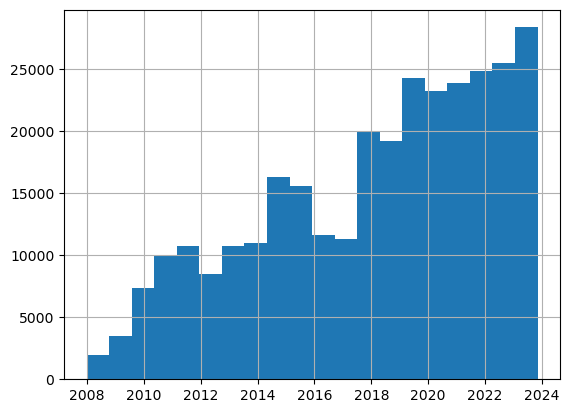

In [86]:
df_ti['reg_date'].hist(bins = 20);

Видим, что число новоприходящих преподавателей увеличивается год от года.

#### Дата рождения ```birth_date```

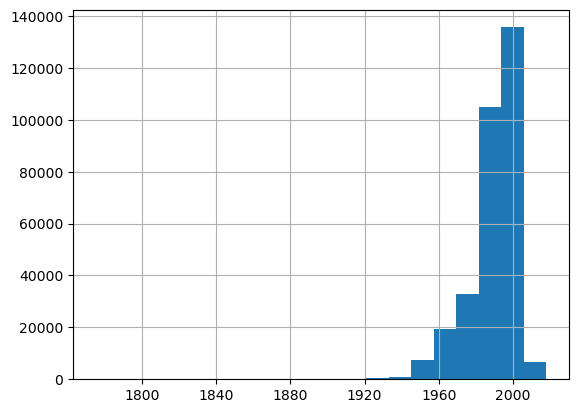

In [87]:
df_ti['birth_date'].hist(bins = 20);

In [88]:
df_ti['birth_date'].nsmallest(30)

292947   1775-02-01
197265   1833-05-08
253126   1843-10-05
165737   1858-05-29
247123   1860-04-12
139285   1868-03-12
139403   1869-02-04
253503   1878-09-25
255790   1881-05-13
286100   1881-07-29
21301    1882-09-30
217277   1883-07-12
158907   1884-02-29
280315   1886-09-01
225553   1889-02-19
167054   1896-05-07
241256   1896-07-22
89324    1900-02-28
197336   1900-06-01
174463   1907-07-16
234130   1909-09-17
3002     1919-01-01
4449     1919-01-01
4450     1919-01-01
4451     1919-01-01
4459     1919-01-01
4614     1919-01-01
6243     1919-01-01
6584     1919-01-01
7403     1919-01-01
Name: birth_date, dtype: datetime64[ns]

Либо вампиры существуют, либо это выбросы. Удалим строки старше 1919 года.

In [89]:
df_ti = df_ti[df_ti['birth_date'].dt.year > 1919]

#### Дата начала обучения ```teaching_start_date```

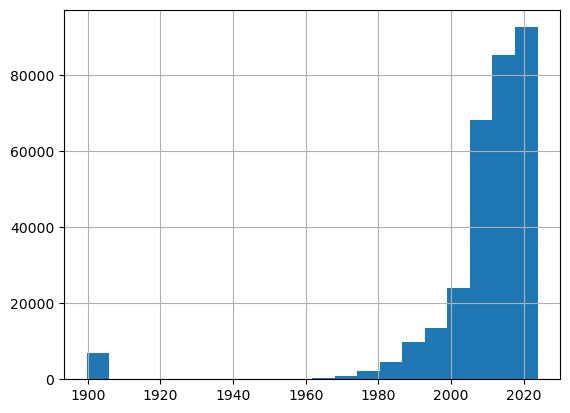

In [90]:
df_ti['teaching_start_date'].hist(bins = 20);

Удаляем выбросы ранее 1960 года.

In [91]:
df_ti = df_ti[df_ti['teaching_start_date'].dt.year > 1960]

#### ИД преподавателя ```user_id```

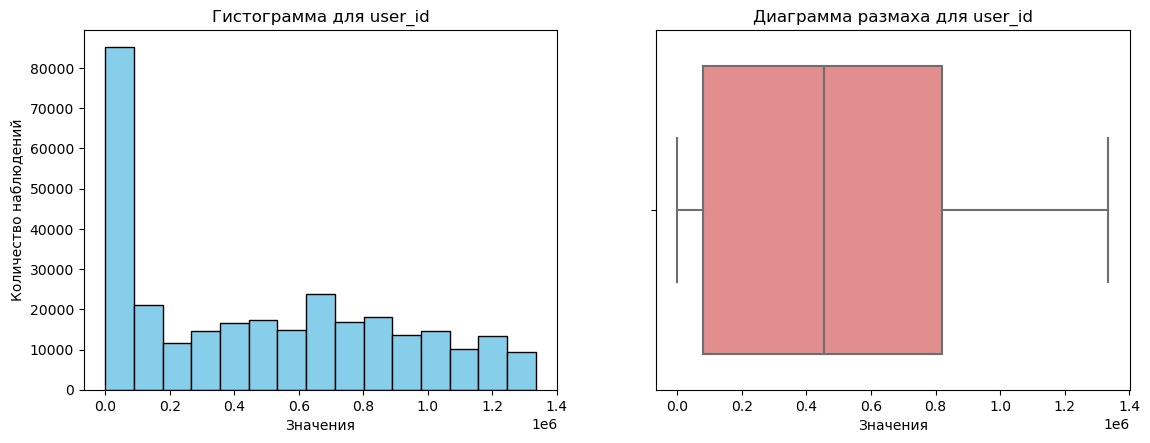

In [92]:
vis(df_ti, 'user_id')

#### Подтвеждение электронной почты ```is_email_confirmed```

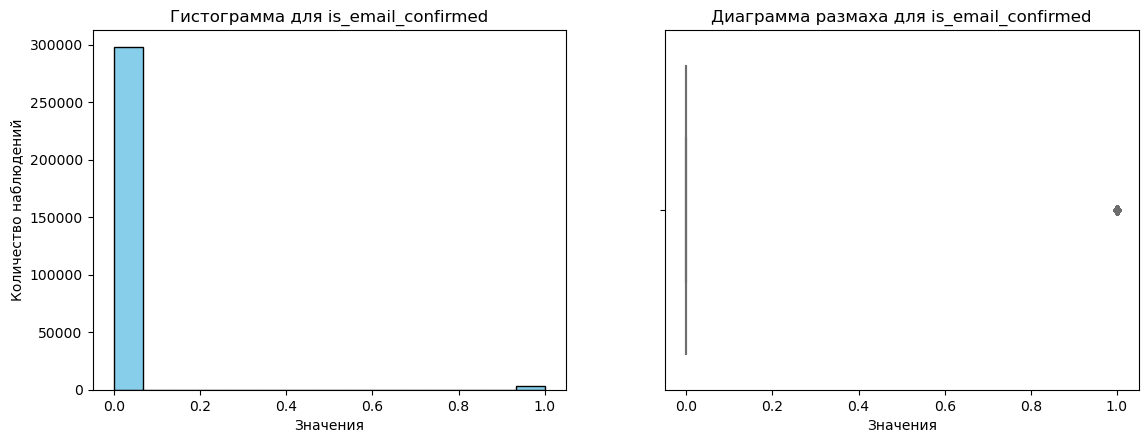

In [93]:
vis(df_ti, 'is_email_confirmed')

Почти все нули, неинформативный признак, удаляем.

In [94]:
df_ti = df_ti.drop('is_email_confirmed', axis = 1)

#### Принимает на дому ```is_home_lessons```

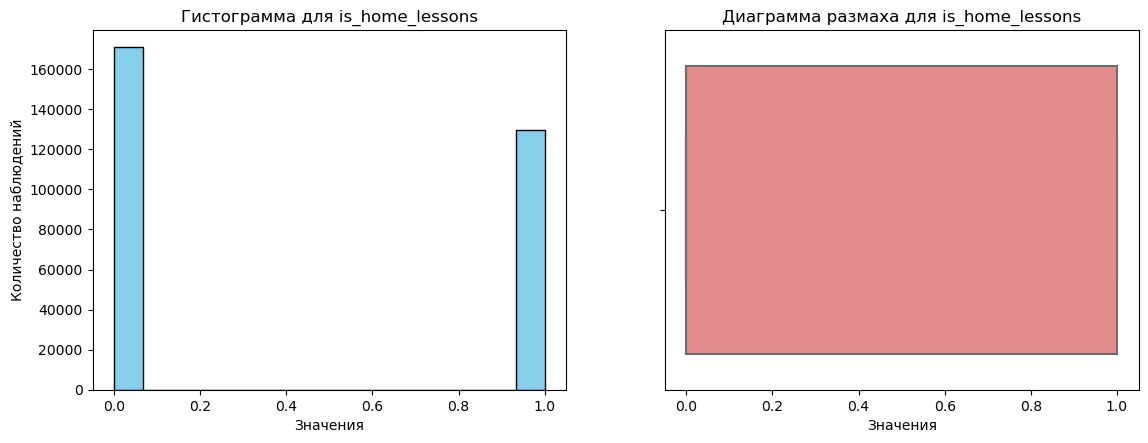

In [95]:
vis(df_ti, 'is_home_lessons')

Аномальных значений нет, оставляем.

#### Выезд на дом ```is_external_lessons```

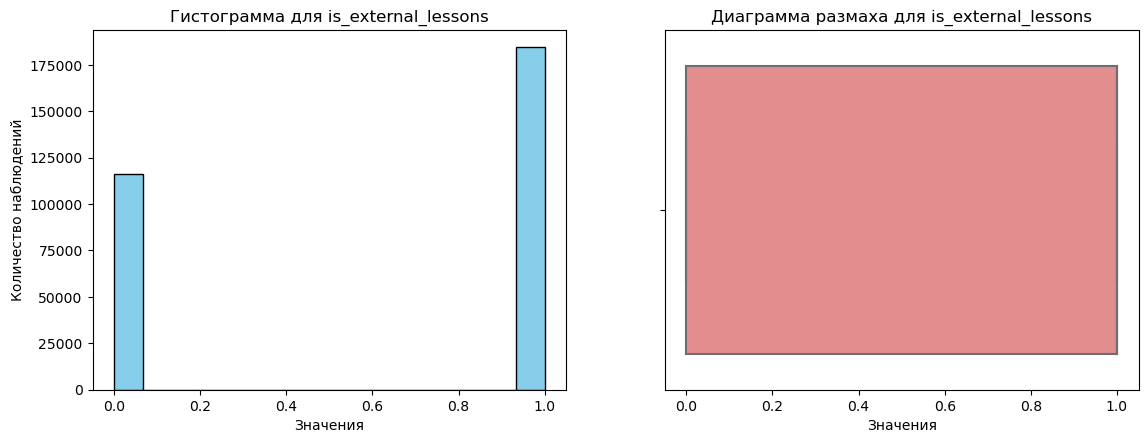

In [96]:
vis(df_ti, 'is_external_lessons')

Всё ок.

#### Продолжительность урока ```lesson_duration```

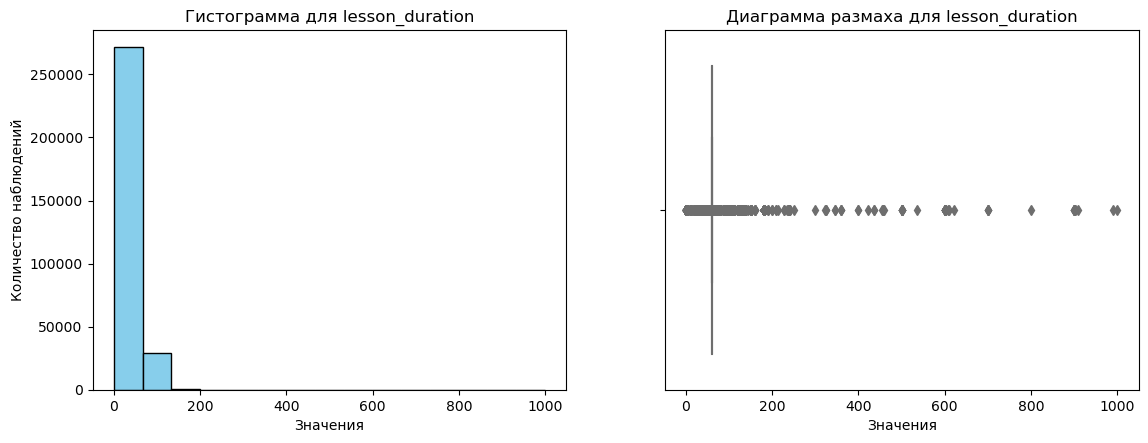

In [97]:
vis(df_ti, 'lesson_duration')

In [98]:
df_ti['lesson_duration'].value_counts()

lesson_duration
60     238203
45      25732
90      25370
40       2870
120      2613
        ...  
10          1
454         1
96          1
213         1
460         1
Name: count, Length: 95, dtype: int64

Заменим аномальные значения на 240.

In [99]:
df_ti.loc[df_ti['lesson_duration'] > 240, 'lesson_duration'] = 240

#### Стоимость занятия ```lesson_cost```

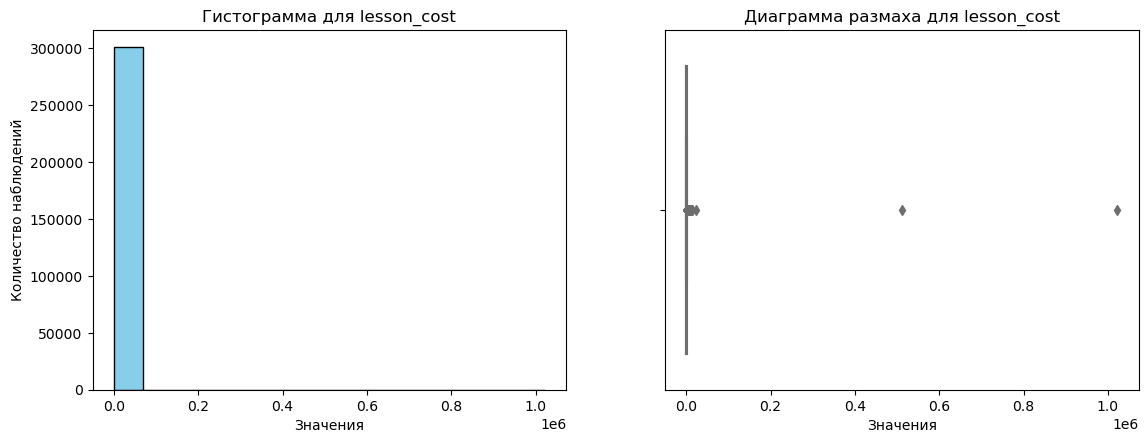

In [100]:
vis(df_ti, 'lesson_cost')

Заменим выбросы на максимальную стоимость урока в 10 тысяч.

In [101]:
df_ti.loc[df_ti['lesson_cost'] > 10000, 'lesson_cost'] = 10000

#### ```status_id```

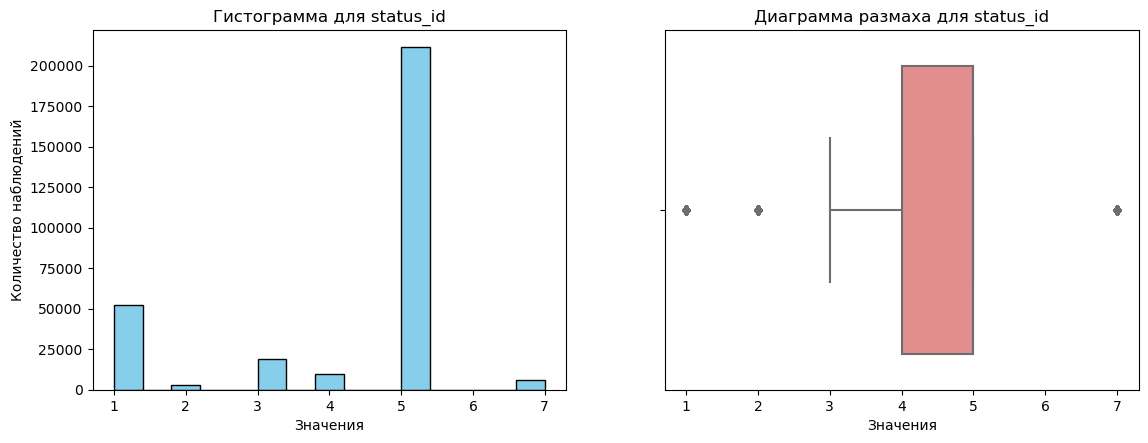

In [102]:
vis(df_ti, 'status_id')

Переименуем столбец, чтобы не было путаницы после объединения таблиц.

In [103]:
df_ti.rename(columns = {'status_id': 'ti_status_id'}, inplace = True)

#### ```status_display```

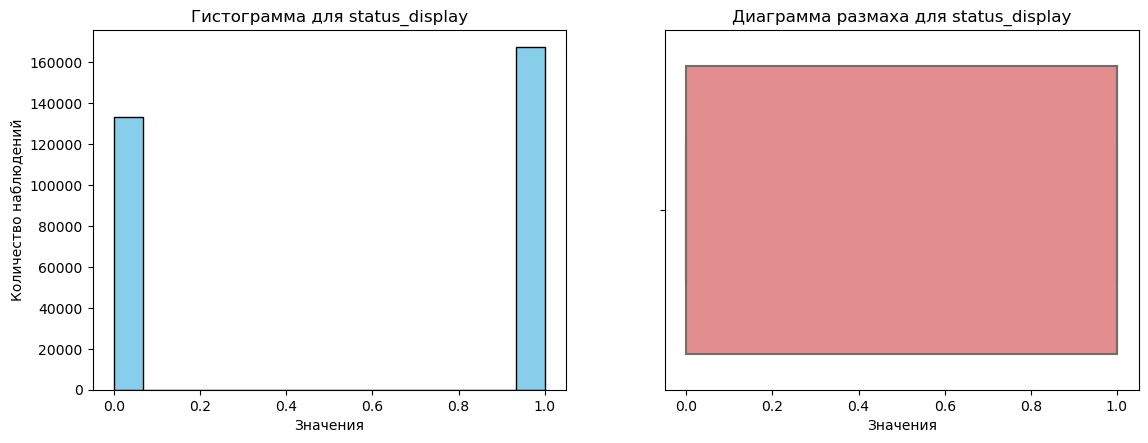

In [104]:
vis(df_ti, 'status_display')

Всё ок.

#### Уровень владения русским ```russian_level_id```

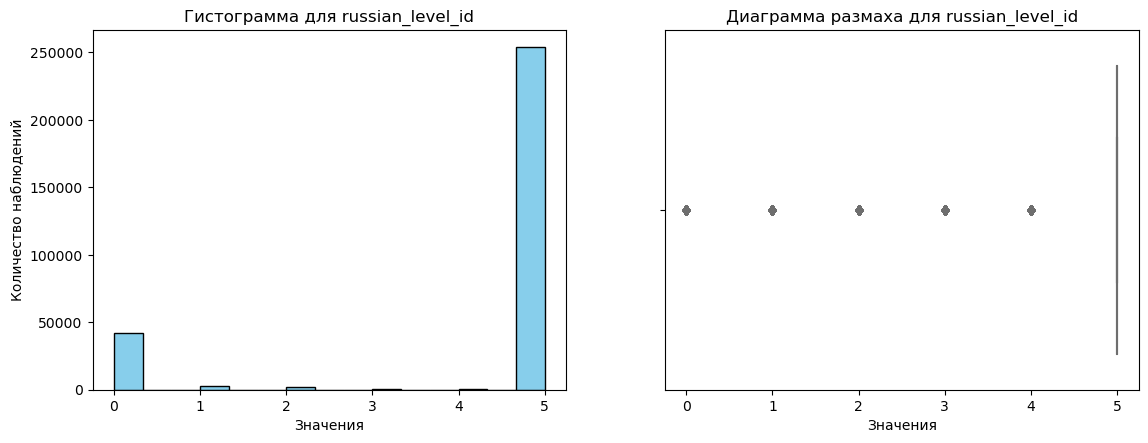

In [105]:
vis(df_ti, 'russian_level_id')

Всё ок.

#### Страна ```home_country_id```

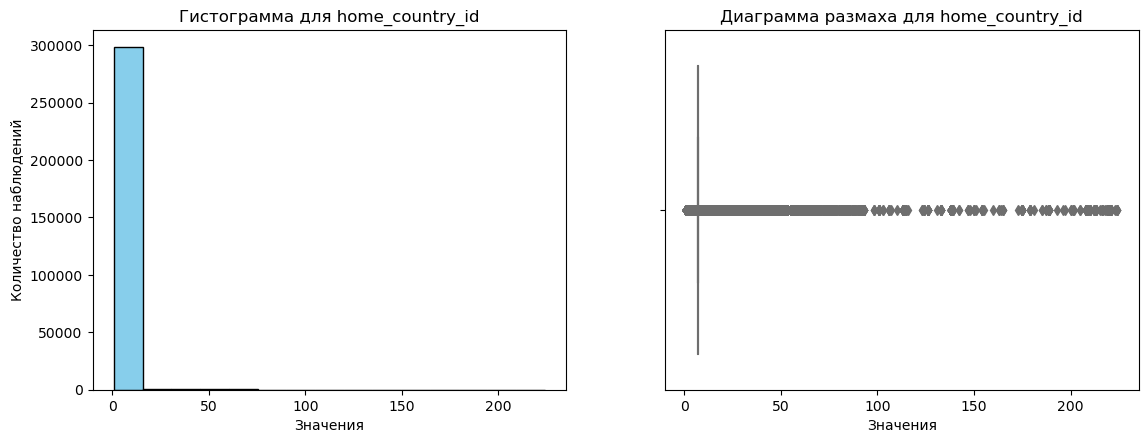

In [106]:
vis(df_ti, 'home_country_id')

In [107]:
df_ti['home_country_id'].value_counts()

home_country_id
7      295119
1         893
13        783
6         248
10        242
        ...  
131         1
215         1
218         1
107         1
148         1
Name: count, Length: 147, dtype: int64

Всё ок, большинство преподавателей из России.

#### ```is_confirmed```

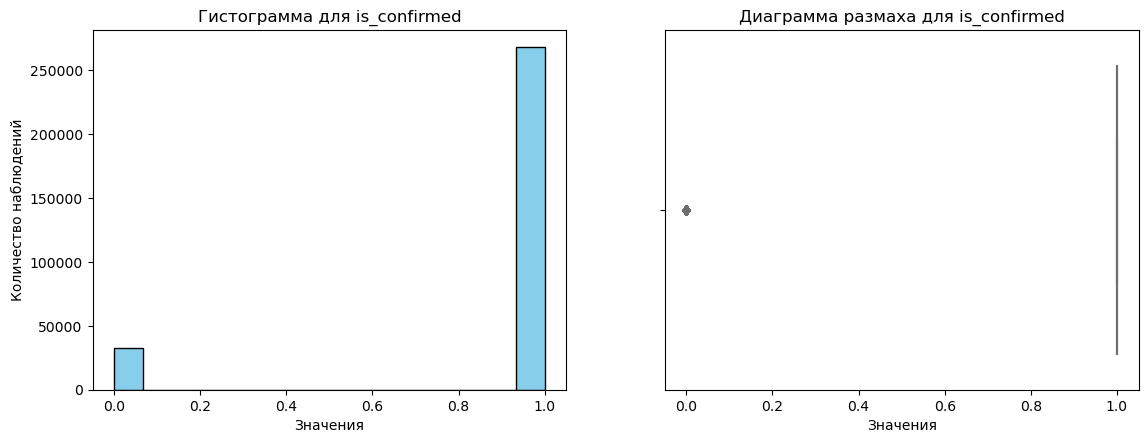

In [108]:
vis(df_ti, 'is_confirmed')

#### ```is_display```

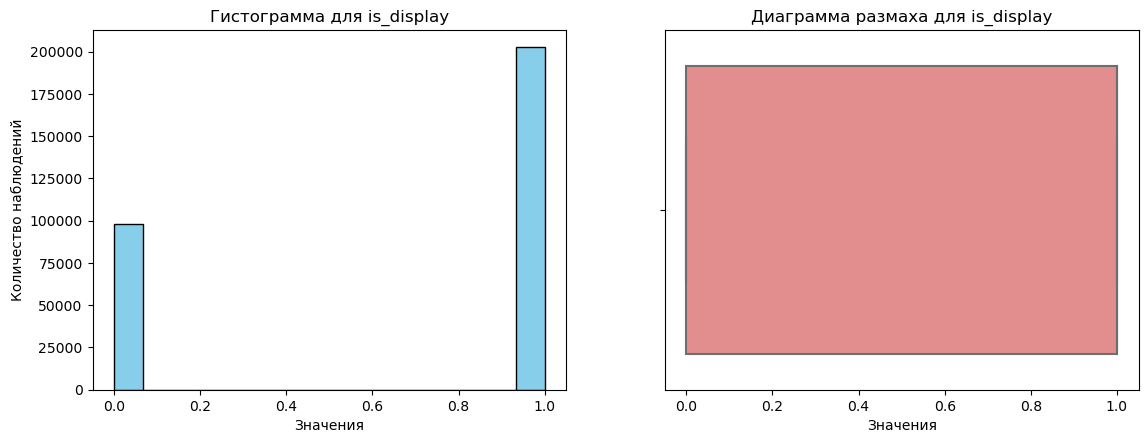

In [109]:
vis(df_ti, 'is_display')

#### ```rating_id```

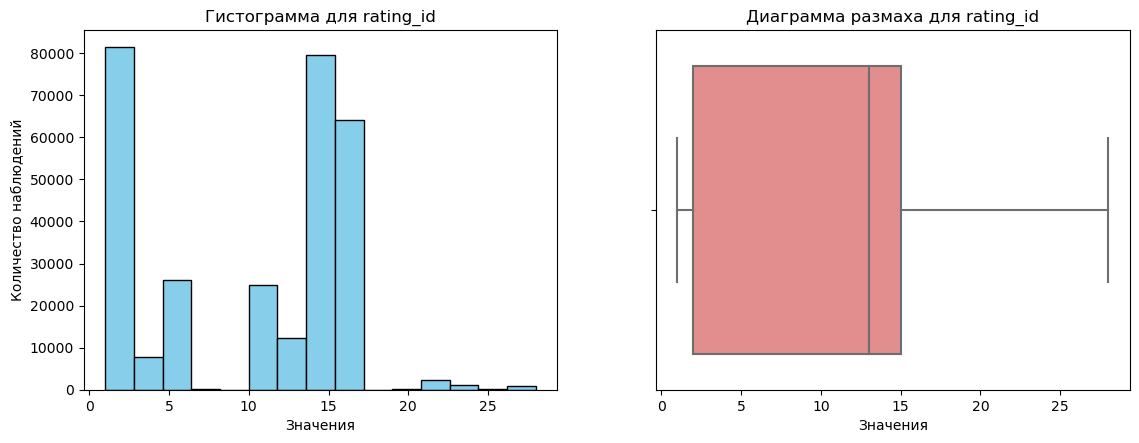

In [110]:
vis(df_ti, 'rating_id')

In [111]:
df_ti['rating_id'].value_counts()

rating_id
15    79330
2     50342
16    45028
1     31080
6     25384
10    24242
17    19137
13    11838
3      7666
22     2068
23      975
5       687
28      679
11      619
12      430
27      273
14      202
8       180
4       137
21      133
7       110
25      106
19       85
18       49
24       36
9        31
Name: count, dtype: int64

Адекватные значения.

#### ```rating```

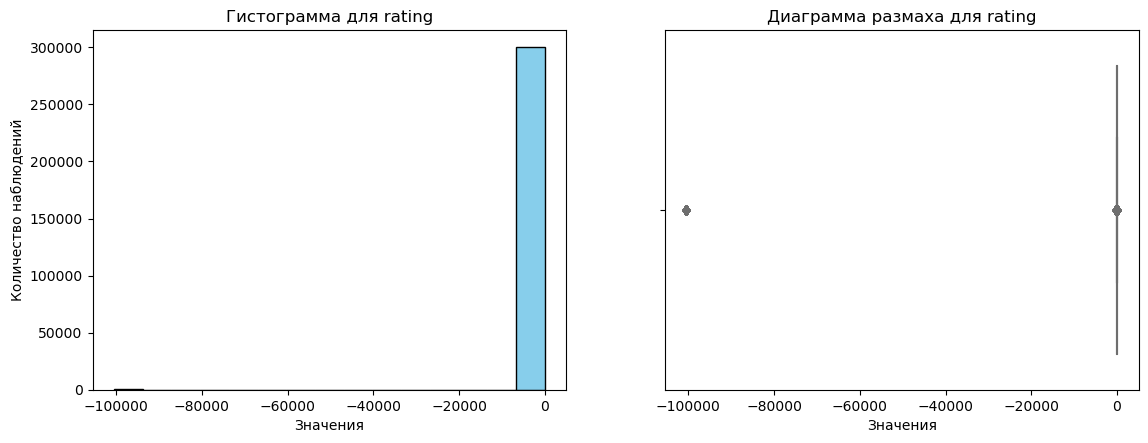

In [112]:
vis(df_ti, 'rating')

In [113]:
df_ti['rating'].value_counts()

rating
 5         79341
-1         50333
 6         45032
 0         31089
-5         25383
-10        24237
 7         19138
-16        11831
-2          7666
-30         2341
 10          975
-4           687
-100500      677
-12          618
-14          430
-25          202
-7           180
-3           137
-17          133
-6           110
-300         106
-50           85
-100          49
-200          36
-8            31
Name: count, dtype: int64

In [114]:
df_ti.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300847 entries, 0 to 307971
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          300847 non-null  int32         
 1   reg_date                    300847 non-null  datetime64[ns]
 2   birth_date                  300847 non-null  datetime64[ns]
 3   teaching_start_date         300847 non-null  category      
 4   user_id                     300847 non-null  int32         
 5   is_home_lessons             300847 non-null  int8          
 6   is_external_lessons         300847 non-null  int8          
 7   lesson_duration             300847 non-null  int16         
 8   lesson_cost                 300847 non-null  int32         
 9   ti_status_id                300847 non-null  int8          
 10  status_display              300847 non-null  int8          
 11  russian_level_id            300847 non-null 

#### ```is_cell_phone_confirmed```

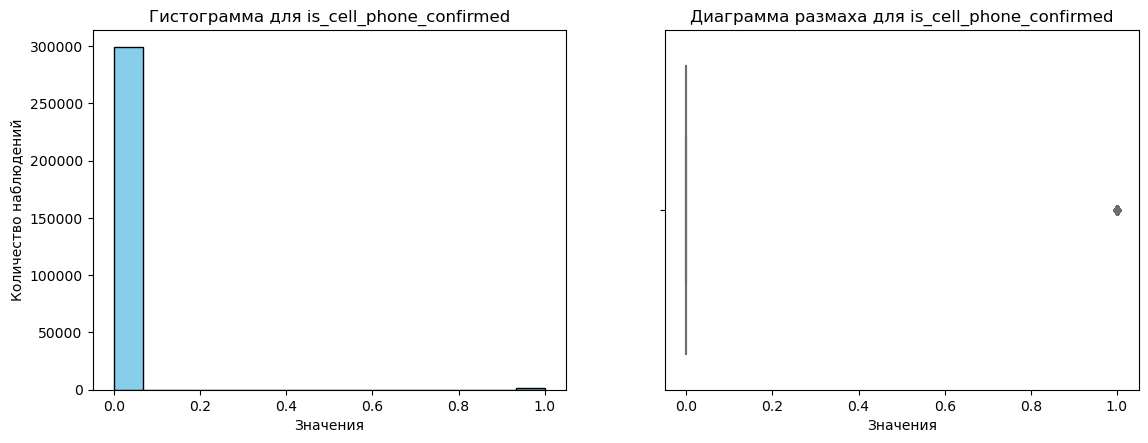

In [115]:
vis(df_ti, 'is_cell_phone_confirmed')

Неинформативный признак, удаляем.

In [116]:
df_ti.drop('is_cell_phone_confirmed', axis = 1, inplace = True)

#### ```effective_rating```

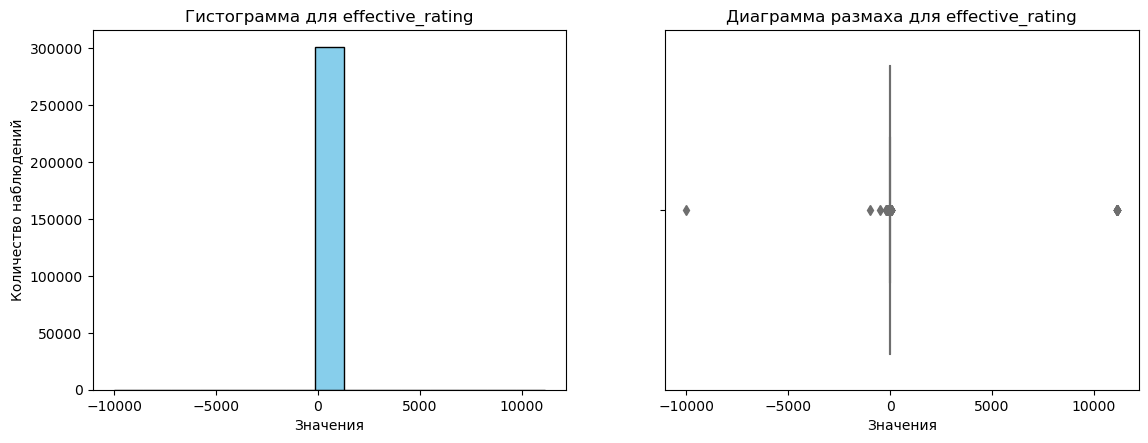

In [117]:
vis(df_ti, 'effective_rating')

In [118]:
df_ti['effective_rating'].value_counts()

effective_rating
 0.000000     239374
 9.000000       8804
-7.000000       7008
 8.000000       6444
-2.000000       6006
               ...  
 3.509766          1
-5.800781          1
-11.242188         1
 12.335938         1
 10.875000         1
Name: count, Length: 2338, dtype: int64

#### ```area_id```

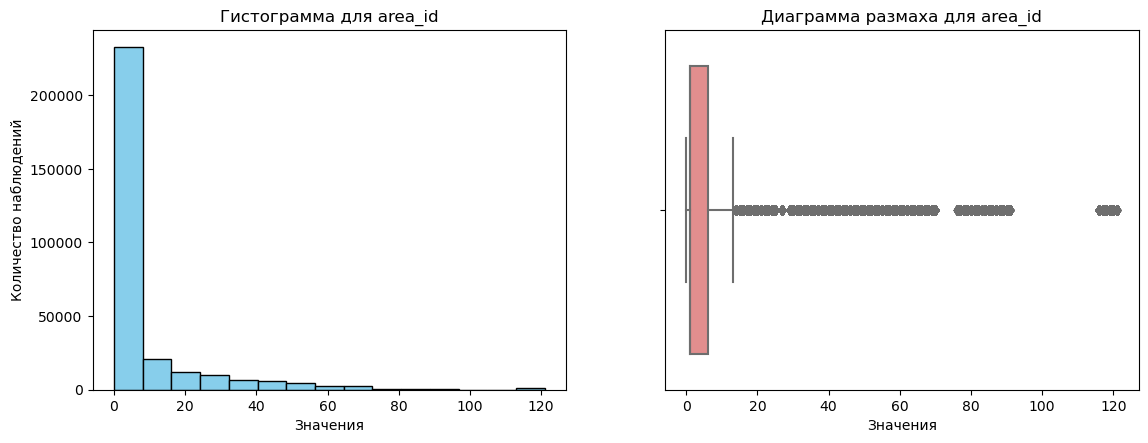

In [119]:
vis(df_ti, 'area_id')

In [120]:
df_ti['area_id'].value_counts()

area_id
1     169317
2      42445
14      5210
4       4591
6       4428
       ...  
78        24
76        20
89        10
83         5
0          1
Name: count, Length: 91, dtype: int64

#### ```sex```

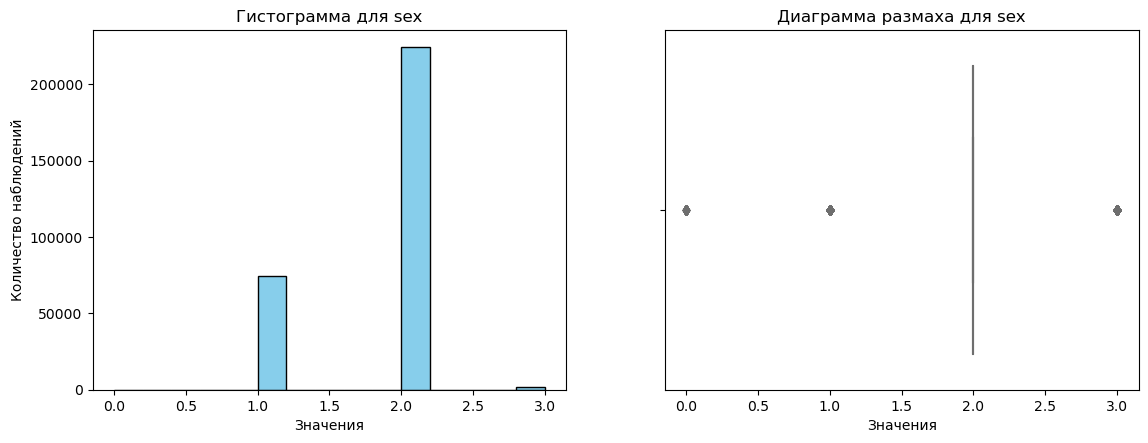

In [121]:
vis(df_ti, 'sex')

In [122]:
df_ti['sex'].value_counts()

sex
2    224159
1     74610
3      2032
0        46
Name: count, dtype: int64

#### ```amount_to_pay```

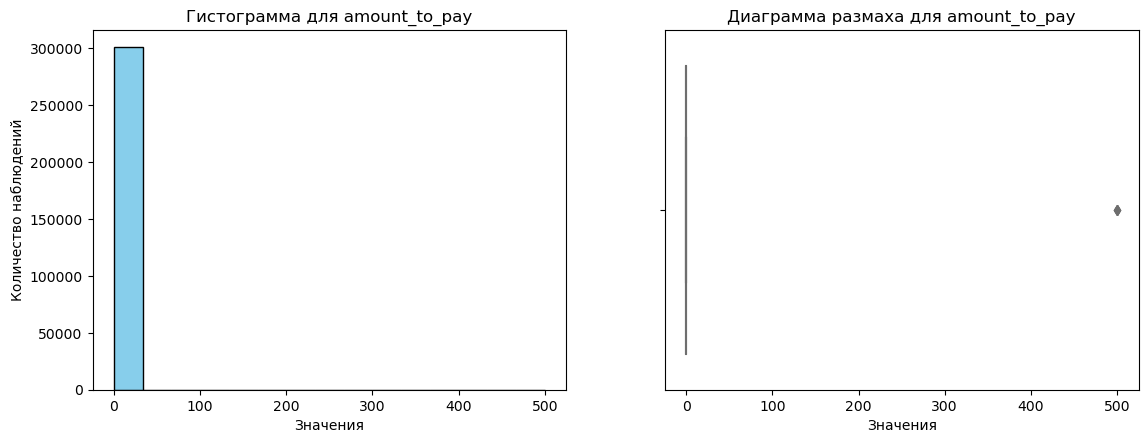

In [123]:
vis(df_ti, 'amount_to_pay')

In [124]:
df_ti['amount_to_pay'].value_counts()

amount_to_pay
0      300844
500         3
Name: count, dtype: int64

Неинформативный признак, удаляем.

In [125]:
df_ti.drop('amount_to_pay', axis = 1, inplace = True)

#### Онлайн-занятия ```is_remote_lessons```

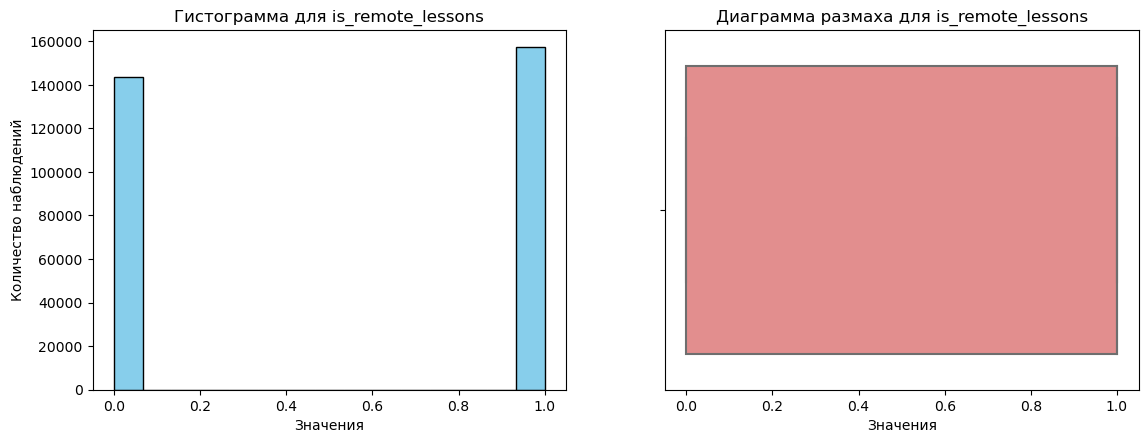

In [126]:
vis(df_ti, 'is_remote_lessons')

Всё ок.

#### ```show_on_map```

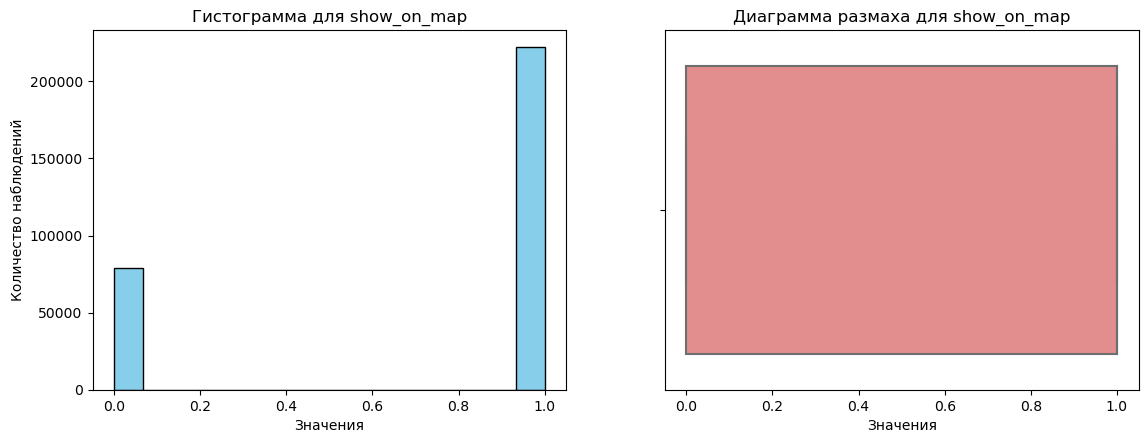

In [127]:
vis(df_ti, 'show_on_map')

Всё ок.

#### ```send_mailing```

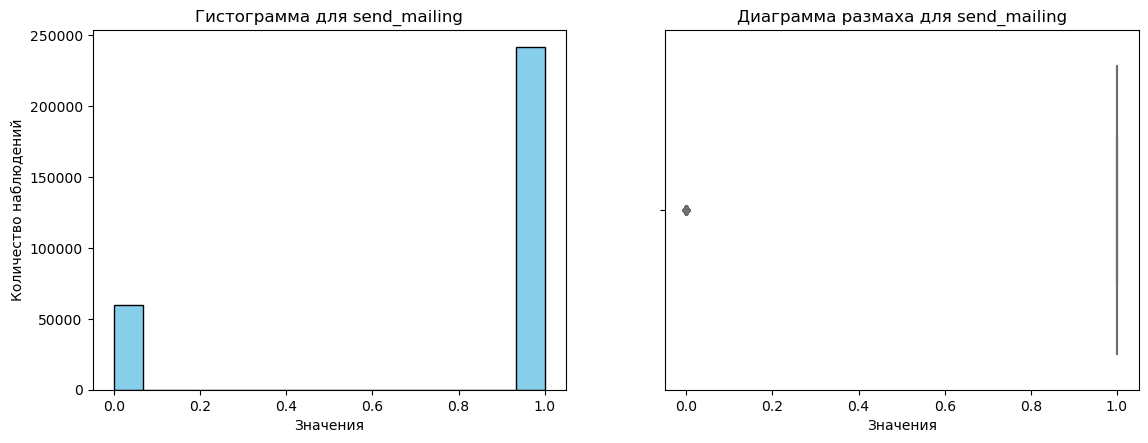

In [128]:
vis(df_ti, 'send_mailing')

In [129]:
df_ti['send_mailing'].value_counts()

send_mailing
1    241290
0     59557
Name: count, dtype: int64

#### ```send_suitable_orders```

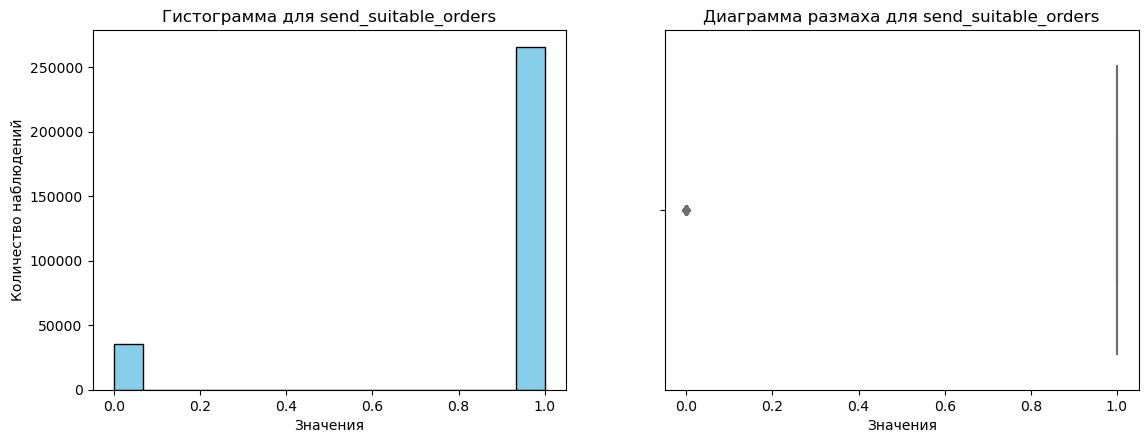

In [130]:
vis(df_ti, 'send_suitable_orders')

In [131]:
df_ti['send_suitable_orders'].value_counts()

send_suitable_orders
1    265436
0     35411
Name: count, dtype: int64

#### ```rating_for_users```

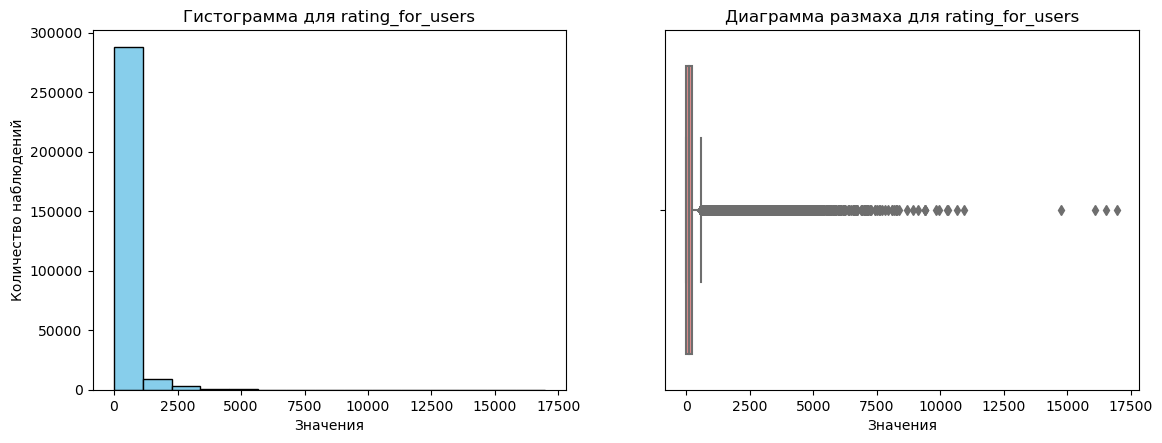

In [132]:
vis(df_ti, 'rating_for_users')

In [133]:
df_ti['rating_for_users'].value_counts()

rating_for_users
0.000       79226
25.000      32341
125.000     23985
150.000     18118
50.000      12967
            ...  
3588.000        1
5848.000        1
171.500         1
222.125         1
4700.000        1
Name: count, Length: 5065, dtype: int64

#### ```rating_for_admin```

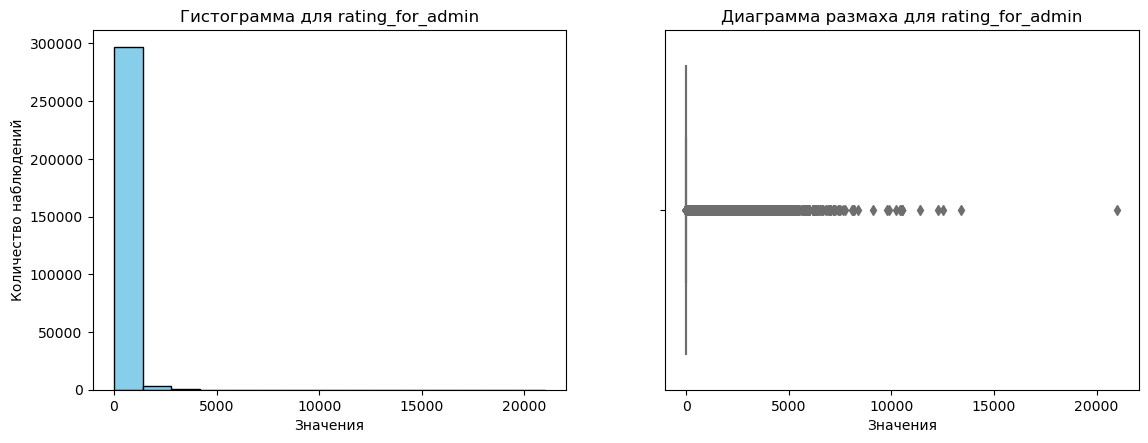

In [134]:
vis(df_ti, 'rating_for_admin')

In [135]:
df_ti['rating_for_admin'].value_counts()

rating_for_admin
0.000000       269229
250.000000        306
125.000000        262
750.000000        222
375.000000        214
                ...  
64.687500           1
5976.000000         1
3832.000000         1
2027.000000         1
30.609375           1
Name: count, Length: 5699, dtype: int64

In [136]:
# удаляем, пока не уточним точное значение признака
df_ti.drop('rating_for_admin', axis = 1, inplace = True)

#### ```is_edited```

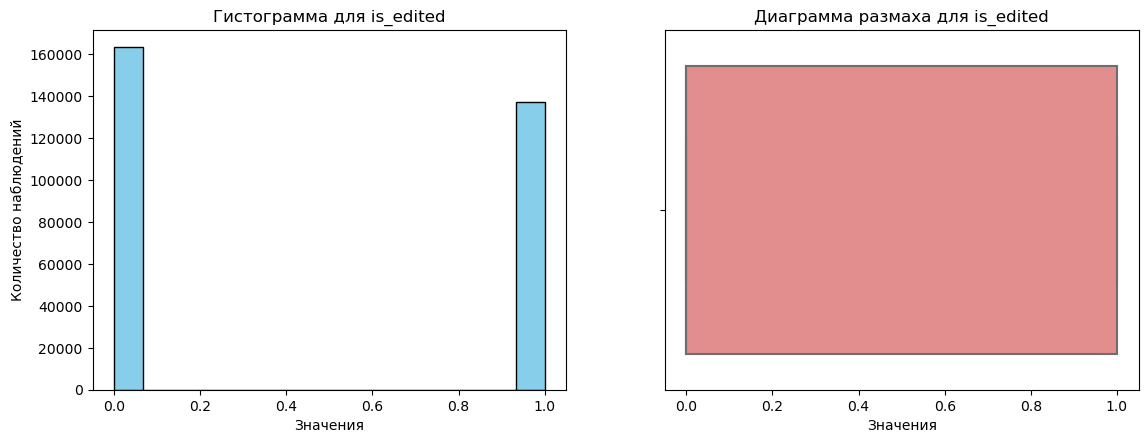

In [137]:
vis(df_ti, 'is_edited')

#### ```orders_allowed```

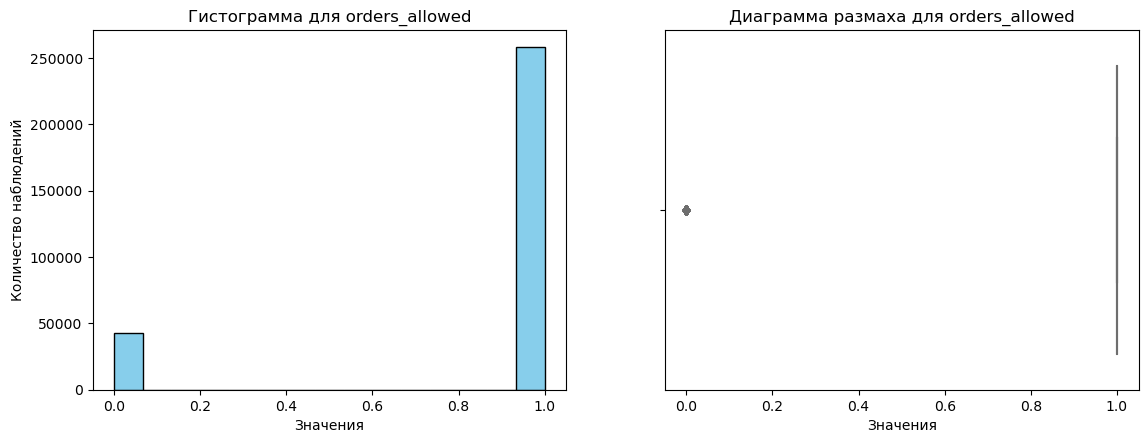

In [138]:
vis(df_ti, 'orders_allowed')

In [139]:
df_ti['orders_allowed'].value_counts()

orders_allowed
1    257961
0     42886
Name: count, dtype: int64

#### ```display_days```

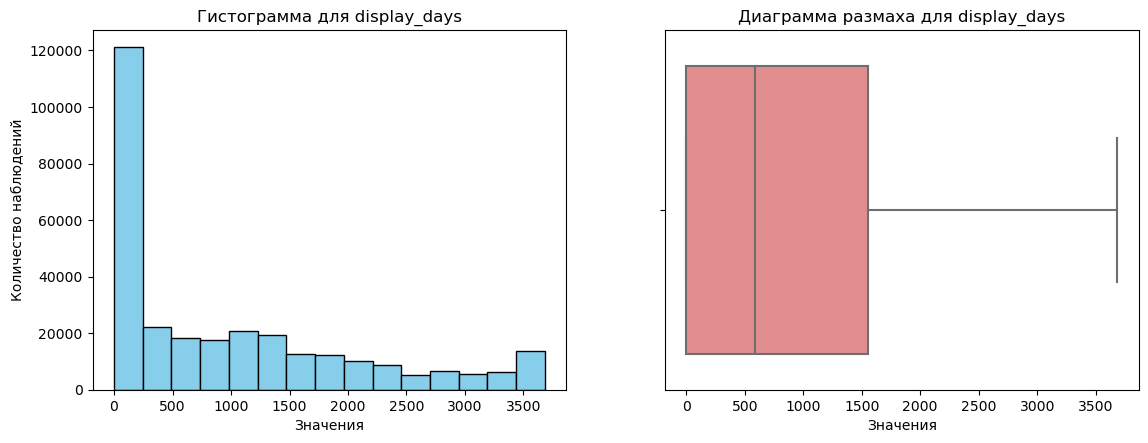

In [140]:
vis(df_ti, 'display_days')

In [141]:
df_ti['display_days'].value_counts()

display_days
0.0       92958
3682.0     6805
1428.0     1023
1144.0      364
1140.0      331
          ...  
1885.0        4
1863.0        3
1829.0        3
1891.0        3
1723.0        2
Name: count, Length: 3890, dtype: int64

#### ```verification_status_id```

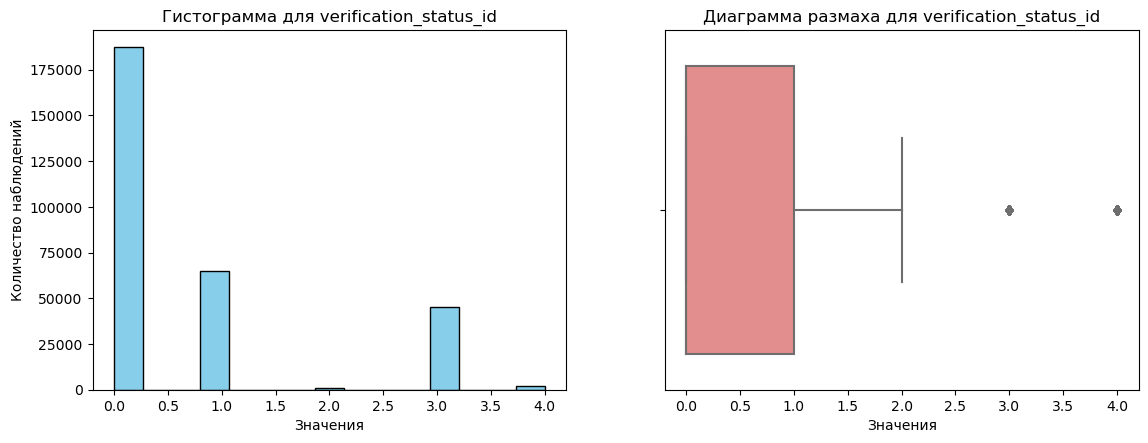

In [142]:
vis(df_ti, 'verification_status_id')

In [143]:
df_ti['verification_status_id'].value_counts()

verification_status_id
0    187319
1     64872
3     45497
4      2128
2      1031
Name: count, dtype: int64

#### ```star_rating```

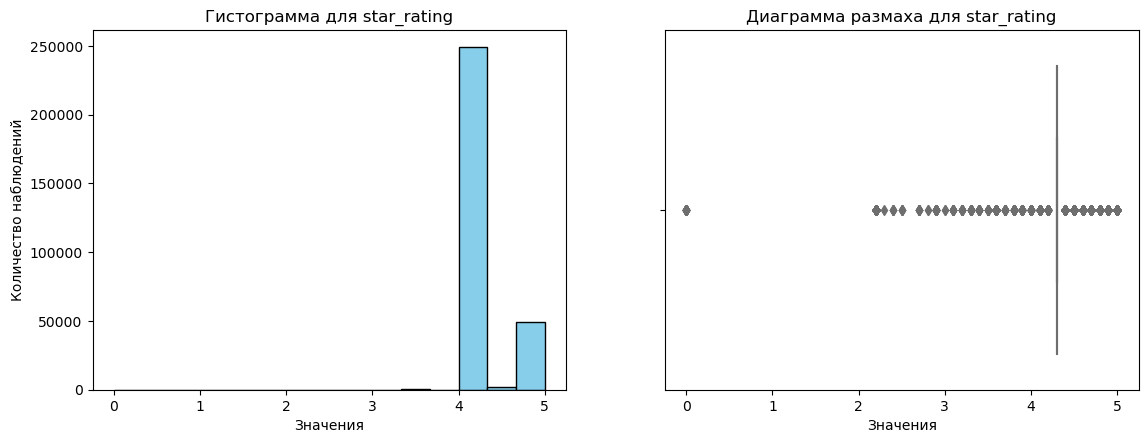

In [144]:
vis(df_ti, 'star_rating')

In [145]:
df_ti['star_rating'].value_counts()

star_rating
4.300781    248706
5.000000     35600
4.898438      6891
4.800781      4333
4.699219      2139
4.601562      1331
4.500000       669
4.398438       235
3.599609       186
2.199219       156
4.101562       111
3.900391        69
4.199219        69
4.000000        65
2.900391        51
3.800781        48
0.000000        44
3.300781        32
3.400391        25
3.199219        17
3.699219        17
3.099609        16
3.500000        13
2.699219         9
2.400391         5
2.500000         5
2.800781         2
3.000000         2
2.300781         1
Name: count, dtype: int64

#### ```rating_for_users_yesterday```

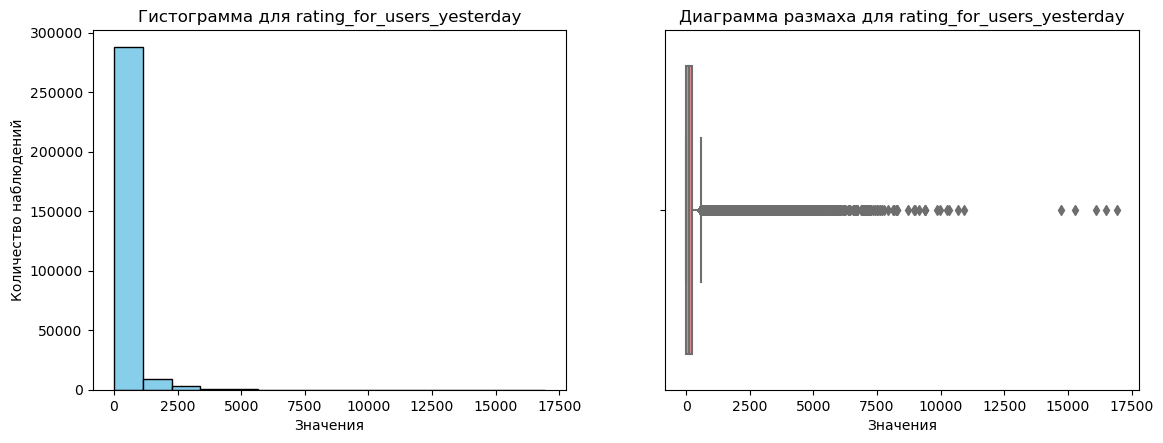

In [146]:
vis(df_ti, 'rating_for_users_yesterday')

In [147]:
df_ti['rating_for_users_yesterday'].value_counts()

rating_for_users_yesterday
0.0000       79319
25.0000      32341
125.0000     23974
150.0000     18109
50.0000      12964
             ...  
206.5000         1
3244.0000        1
228.1250         1
116.3125         1
4552.0000        1
Name: count, Length: 5061, dtype: int64

#### ```review_num```

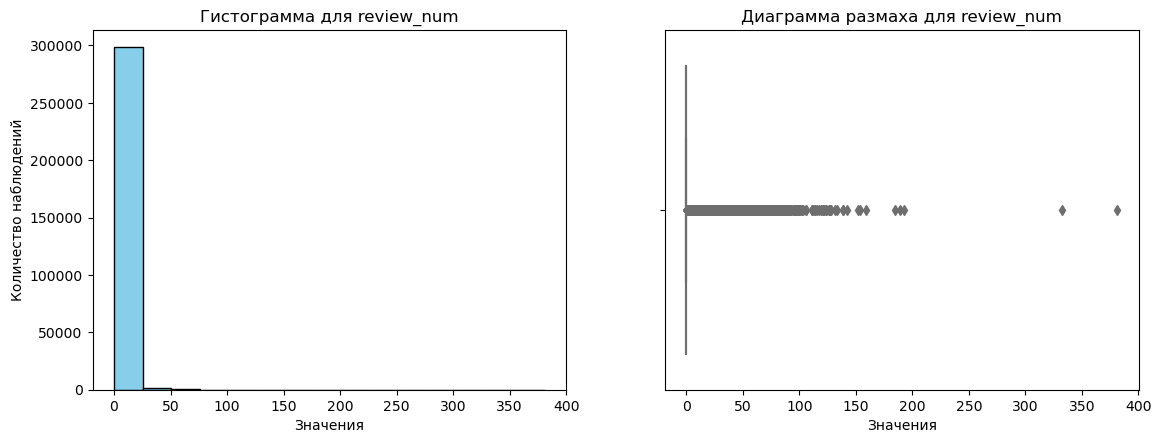

In [148]:
vis(df_ti, 'review_num')

In [149]:
df_ti['review_num'].value_counts()

review_num
0      246565
1       17857
2        8465
3        5271
4        3841
        ...  
154         1
159         1
89          1
189         1
132         1
Name: count, Length: 130, dtype: int64

#### ```is_display_at_partners```

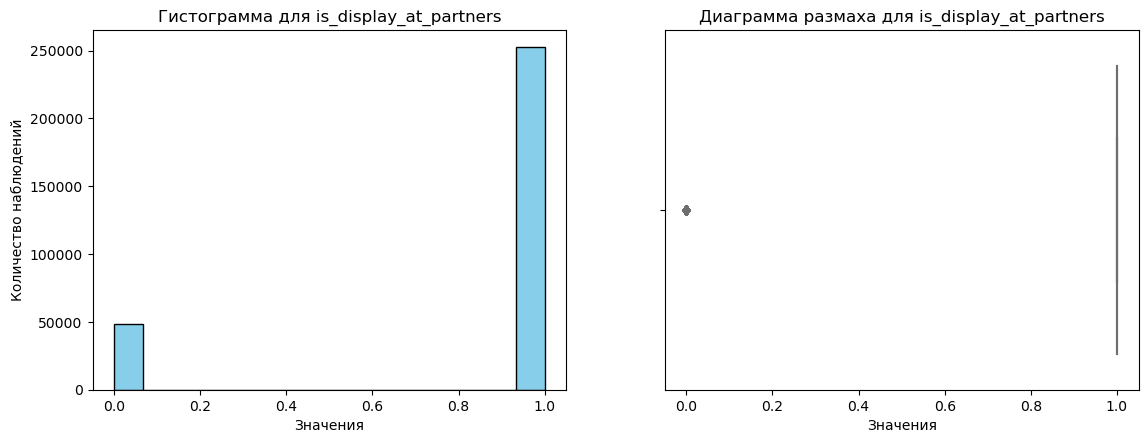

In [150]:
vis(df_ti, 'is_display_at_partners')

In [151]:
df_ti['is_display_at_partners'].value_counts()

is_display_at_partners
1    252553
0     48294
Name: count, dtype: int64

## Промежуточный вывод 2:

- удалены дубликаты столбцов и столбцы с пропусками
- столбцы с датами приведены к соответстующему типу
- удалены следующие признаки, как неинформативные (почти все значения были либо 1 либо 0): ```is_email_confirmed```, ```is_cell_phone_confirmed```, ```amount_to_pay```
- обработаны выбросы в столбце с продолжительностью занятия и стоимостью

## Обработка дублей в таблице заявок

Нам известно, что на один ```client_id``` могут приходиться несколько заявок. Те заявки, в которых ```original_order_id``` не указан, можно сгруппировать по ```client_id``` и заполнить предыдущими или следующими значениями. Так мы избавимся от большей части пропусков. Оставшиеся пропуски, по сути, будут являться единичными, оригинальными заявками.

In [152]:
df_orders['original_order_id'].isna().sum()

605687

In [153]:
# сортируем по дате и заполняем пропуски
df_orders.sort_values(by=['client_id', 'order_date'], inplace=True)
df_orders['original_order_id'] = df_orders.groupby('client_id')['original_order_id'].bfill()
df_orders['original_order_id'] = df_orders.groupby('client_id')['original_order_id'].ffill()

In [154]:
df_orders['original_order_id'].isna().sum()

265051

Количество пропусков уменьшилось почти в 3 раза. Оставшиеся данные - оригинальные заявки.

In [155]:
df_orders[df_orders['client_id'] == 225633]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,estimated_fee,is_display_to_teachers
63966,2358027,2022-12-05 15:00:23.617,3.0,Разделы: общий курс.\nКатегория ученика: девуш...,1800,60,0.0,Место проведения занятий: дистанционно (наприм...,1,4680.0,10,15.0,2,0,3,0,0,4,2,0,0,1,0,16,NaN,225633,4680.0,1
63980,2358041,2022-12-05 15:03:26.840,2.0,Разделы: общий курс.\nКатегория ученика: девуш...,2500,60,0.0,Место проведения занятий: дистанционно (наприм...,1,0.0,10,15.0,2,0,3,0,0,4,2,0,0,1,0,16,NaN,225633,0.0,1


In [156]:
df_orders[df_orders['client_id'] == 225648]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,estimated_fee,is_display_to_teachers
84113,1827525,2021-10-18 22:36:48.023,2.0,Не указано,0,60,0.0,Не указано,0,0.0,0,0.0,0,0,3,0,0,0,0,0,0,0,0,8,NaN,225648,0.0,1
137649,1979240,2022-02-22 09:56:03.927,1.0,Не указано,0,60,0.0,Не указано,0,0.0,0,0.0,0,0,3,0,0,0,0,0,0,0,0,8,NaN,225648,0.0,1
246220,2089462,2022-06-21 09:16:39.843,2.0,Категория ученика: взрослая женщина\nУровень з...,1500,60,0.0,Место проведения занятий: дистанционно (наприм...,1,2025.0,10,15.0,2,700,3,0,0,4,3,0,0,1,0,17,NaN,225648,4050.0,1


Видим, что даже с пропусками в ```original_orders_id```, при одинаковых ```client_id``` есть как оплаченные, так и неоплаченные заявки.

In [157]:
df_orders[(df_orders['original_order_id'].isna()) & (df_orders['status_id'] == 1)]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,estimated_fee,is_display_to_teachers
44441,1886011,2021-12-10 12:29:56.110,10.0,Разделы: python.\nДополнения: ЕГЭ.\nКатегория ...,1200,60,0.0,Место проведения занятий: дистанционно (наприм...,1,3250.0,10,11.0,3,0,3,0,0,4,0,18,80,1,0,16,NaN,225182,3900.0,1
47211,2445836,2023-01-27 16:09:06.797,2.0,Разделы: общий курс.\nКатегория ученика: взрос...,1500,60,464.0,Район: г. Сестрорецк.\nМесто проведения заняти...,1,2600.0,10,15.0,4,0,3,3,0,2,1,23,0,0,0,16,NaN,225565,3900.0,1
63966,2358027,2022-12-05 15:00:23.617,3.0,Разделы: общий курс.\nКатегория ученика: девуш...,1800,60,0.0,Место проведения занятий: дистанционно (наприм...,1,4680.0,10,15.0,2,0,3,0,0,4,2,0,0,1,0,16,NaN,225633,4680.0,1
63980,2358041,2022-12-05 15:03:26.840,2.0,Разделы: общий курс.\nКатегория ученика: девуш...,2500,60,0.0,Место проведения занятий: дистанционно (наприм...,1,0.0,10,15.0,2,0,3,0,0,4,2,0,0,1,0,16,NaN,225633,0.0,1
246220,2089462,2022-06-21 09:16:39.843,2.0,Категория ученика: взрослая женщина\nУровень з...,1500,60,0.0,Место проведения занятий: дистанционно (наприм...,1,2025.0,10,15.0,2,700,3,0,0,4,3,0,0,1,0,17,NaN,225648,4050.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347269,2935284,2023-11-05 05:35:55.797,1.0,Цели: углубленное изучение.\nКатегория ученика...,2500,60,0.0,Желаемое время для занятий: понедельник - 10.\...,1,3000.0,10,8.0,3,0,3,0,0,4,0,0,0,0,0,23,NaN,1268097,7500.0,0
347420,2935435,2023-11-05 10:36:44.720,8.0,"Цели: помощь по школьной программе, углубленно...",1500,60,0.0,Желаемое время для занятий: вторник - 16; четв...,1,4800.0,10,7.0,3,0,3,0,0,4,0,0,0,0,0,23,NaN,1268166,4800.0,0
348096,2936111,2023-11-05 16:57:08.617,1.0,Цели: итоговое сочинение.\nДополнения: ЕГЭ.\nК...,1500,60,0.0,"Желаемое время для занятий: воскресенье - 11, ...",1,7000.0,10,12.0,3,0,3,0,0,4,0,0,0,0,0,23,NaN,1268405,5250.0,0
348203,2936218,2023-11-05 17:59:26.210,11.0,Категория ученика: школьник 8 класса.\nЦель за...,700,60,0.0,Место проведения занятий: дистанционно (наприм...,1,2030.0,10,9.0,3,0,2,0,0,4,0,0,0,0,0,8,NaN,1268449,2030.0,1


Присвоим таким пропускам номер заявки из столбца ```id```

In [158]:
df_orders['original_order_id'] = df_orders['original_order_id'].fillna(df_orders['id'])

Проверяем группы заявок с одинаковым ```original_order_id``` и заменяем ```status_id``` на 1, если хотя бы у одной заявки в группе есть статус 1.

Дополнительно, проверим группы заявок по ИД клиентов. Если клиент оплатил более 7 заявок, то он постоянный и все заявки от этого клиента будем помечать как оплаченные.

In [159]:
df_orders['new_status'] = df_orders.groupby('original_order_id')['status_id'].transform(lambda x: 1 if (x == 1).any() else 0)
df_orders.loc[df_orders['new_status'] == 1, 'status_id'] = 1

df_orders.drop('new_status', axis=1, inplace=True)

def replace_status(x):
    return 1 if (x == 1).sum() >= 7 else 0

df_orders['new_status'] = df_orders.groupby('client_id')['status_id'].transform(replace_status)
df_orders.loc[df_orders['new_status'] == 1, 'status_id'] = 1

df_orders.drop('new_status', axis=1, inplace=True)

In [160]:
df_orders[df_orders['status_id'] == 1]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,estimated_fee,is_display_to_teachers
83056,1826466,2021-10-18 13:23:31.520,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,900,60,134.0,Район: м. Бибирево.\nМесто проведения занятий:...,1,275.0,10,8.0,4,600,2,1,0,1,0,0,30,0,0,16,1826466.0,155290,2880.0,1
83070,1826482,2021-10-18 13:32:02.220,8.0,"\n​Разделы : школьный курс, геометрия \n​Допо...",0,60,134.0,\n​Место проведения занятий : у ученика(Алтуфь...,1,0.0,10,8.0,5,900,2,1,0,1,0,18,30,0,0,16,1826466.0,155290,0.0,1
84267,1827679,2021-10-19 08:52:25.287,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,900,60,134.0,Район: м. Бибирево.\nМесто проведения занятий:...,1,0.0,10,8.0,4,600,2,1,0,1,0,0,30,0,0,14,1826466.0,155290,2880.0,1
39495,1881065,2021-12-06 10:52:10.330,13.0,Разделы: школьный курс.\nКатегория ученика: ш...,1000,60,134.0,Район: м. Бибирево.\nМесто проведения занятий:...,1,1500.0,7,8.0,7,800,3,0,0,4,0,0,50,0,0,16,1881065.0,155290,1500.0,1
39497,1881067,2021-12-06 10:53:00.510,13.0,Не указано,0,60,134.0,Не указано,1,0.0,0,0.0,0,0,2,0,0,4,0,0,50,0,0,16,1881065.0,155290,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348203,2936218,2023-11-05 17:59:26.210,11.0,Категория ученика: школьник 8 класса.\nЦель за...,700,60,0.0,Место проведения занятий: дистанционно (наприм...,1,2030.0,10,9.0,3,0,2,0,0,4,0,0,0,0,0,8,2936218.0,1268449,2030.0,1
348372,2936387,2023-11-05 19:36:36.527,1.0,Не указано,0,60,0.0,Не указано,1,0.0,0,0.0,0,0,3,0,0,0,0,0,0,0,0,16,2936390.0,1268503,0.0,1
348375,2936390,2023-11-05 19:38:42.373,1.0,"Цели: итоговое сочинение.\nДополнения: ЕГЭ, ОГ...",700,60,1258.0,"Адрес ученика: г Оренбург, ул Мичурина.\nЖелае...",1,0.0,10,10.0,3,0,3,0,0,1,0,0,0,0,0,16,2936390.0,1268503,1050.0,0
348392,2936407,2023-11-05 19:53:32.490,1.0,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 ...,700,60,1258.0,"Адрес ученика: г Оренбург, ул Мичурина.\nЖелае...",1,1470.0,10,10.0,3,0,3,0,0,1,0,0,0,0,0,14,2936390.0,1268503,1470.0,1


## Создание новых признаков 

### Таблица заявок ```df_orders```

```order_date```, ```purpose```, ```add_info```, ```teachers_experience_from/to```, ```teachers_age_from/to``` - обработаем эти столбцы для формирования новых признаков.

### Время, день и месяц заказа

Вытащим числовые значения дня и месяца из ```order_date```.

In [161]:
df_orders['order_date']

230059   2022-06-01 01:00:45.017
26273    2023-02-28 13:01:28.767
26279    2023-02-28 13:06:14.050
26282    2023-02-28 13:07:52.817
26284    2023-02-28 13:07:55.423
                   ...          
348662   2023-11-05 23:52:18.940
348663   2023-11-05 23:54:21.590
348665   2023-11-05 23:57:23.717
348666   2023-11-05 23:58:07.547
348668   2023-11-05 23:58:31.963
Name: order_date, Length: 1181287, dtype: datetime64[ns]

In [162]:
df_orders['order_day'] = df_orders['order_date'].dt.day
df_orders['order_month'] = df_orders['order_date'].dt.month
df_orders['order_hour'] = df_orders['order_date'].dt.hour

In [163]:
df_orders = df_orders.drop('order_date', axis = 1)

### Цель заказа purpose

Данный столбец заполняется по шаблону. Вытащим категориальные признаки по ключевым словам.

In [164]:
df_orders['purpose']

230059    Дополнения:\nподготовка к олимпиадам.\nКатегор...
26273     Разделы:  школьный курс.\nКатегория ученика: ш...
26279          Цели: другое.\nКатегория ученика: 6-7 лет.\n
26282     Разделы:  школьный курс.\nКатегория ученика: ш...
26284     Разделы:  школьный курс.\nКатегория ученика: ш...
                                ...                        
348662    Разделы: общий курс.\nКатегория ученика: школь...
348663    Цели: углубленное изучение.\nКатегория ученика...
348665    Категория ученика: взрослый.\nЦель занятий: по...
348666    Дополнения: ЕГЭ.\nКатегория ученика: 11 класс....
348668    Разделы: черчение.\nКатегория ученика: 9 класс.\n
Name: purpose, Length: 1181287, dtype: object

In [165]:
keywords = ['Дополнения', 'Разделы', 'Цели', 'Категория ученика']

for keyword in keywords:
    # создаем новый столбец, где будут значения, соответствующие ключевому слову
    df_orders[keyword.replace(' ', '_')] = df_orders['purpose'].str.extract(f"{keyword}: ([^:\n]+)")


In [166]:
df_orders.head()

,id,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,estimated_fee,is_display_to_teachers,order_day,order_month,order_hour,Дополнения,Разделы,Цели,Категория_ученика
230059,2073301,1.0,Дополнения:\nподготовка к олимпиадам.\nКатегор...,1500,60,34.0,Адрес: 10 vby.\nВремя: Подстроюсь под репетито...,0,0.0,10,16.0,4,0,3,5,0,1,0,0,0,0,0,23,2504890.0,1,0.0,1,1,6,1,NaN,NaN,NaN,4-5 лет.
26273,2504890,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,1500,60,0.0,Место проведения занятий: дистанционно (наприм...,0,0.0,10,7.0,5,1000,3,0,0,4,0,0,0,0,0,23,2504890.0,1,4950.0,1,28,2,13,NaN,школьный курс.,улучшить успеваемость.,школьник 6 класса.
26279,2504896,8.0,Цели: другое.\nКатегория ученика: 6-7 лет.\n,1500,60,0.0,"Желаемое время для занятий: вторник - 13, 14, ...",0,0.0,10,1.0,5,0,3,0,0,4,0,0,0,0,0,23,2504890.0,1,0.0,1,28,2,13,NaN,NaN,другое.,6-7 лет.
26282,2504899,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,1500,60,0.0,Место проведения занятий: дистанционно (наприм...,0,0.0,10,7.0,5,1000,3,0,0,4,0,0,0,0,0,14,2504890.0,1,5100.0,1,28,2,13,NaN,школьный курс.,улучшить успеваемость.,школьник 6 класса.
26284,2504901,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,1500,60,0.0,Место проведения занятий: дистанционно (наприм...,0,0.0,10,7.0,5,1000,3,0,0,4,0,0,0,0,0,14,2504890.0,1,4950.0,1,28,2,13,NaN,школьный курс.,улучшить успеваемость.,школьник 6 класса.


In [167]:
# проверяем пропуски
for i in ['Дополнения' ,'Разделы', 'Цели', 'Категория_ученика']:
    print(f'Количество пропусков в {i}:', df_orders[i].isna().sum())

Количество пропусков в Дополнения: 817914
Количество пропусков в Разделы: 499107
Количество пропусков в Цели: 1017345
Количество пропусков в Категория_ученика: 196444


Целесообразным будет оставить разделы и категории ученика. Заполним пропуски на «не указано», удалим неинформативные и исходный столбцы.

In [168]:
df_orders.rename(columns={'Разделы': 'section', 'Категория_ученика': 'pupil_category'}, inplace = True)
df_orders.drop(['Дополнения', 'Цели', 'purpose'], axis = 1, inplace = True)

In [169]:
df_orders[['section', 'pupil_category']] = df_orders[['section', 'pupil_category']].fillna('Не указано')

### Дополнительная информация о заказе add_info

Данный столбец так же заполняется по шаблону. Вытащим категориальные признаки.

In [170]:
display(df_orders['add_info'])

230059    Адрес: 10 vby.\nВремя: Подстроюсь под репетито...
26273     Место проведения занятий: дистанционно (наприм...
26279     Желаемое время для занятий: вторник - 13, 14, ...
26282     Место проведения занятий: дистанционно (наприм...
26284     Место проведения занятий: дистанционно (наприм...
                                ...                        
348662    Район: г. Люберцы.\nМесто проведения занятий: ...
348663    Количество занятий в неделю: 1-2.\nВозраст реп...
348665    Район: Ленинский район.\nМесто проведения заня...
348666    Желаемое время для занятий: понедельник - в лю...
348668    Желаемое время для занятий: понедельник - 15, ...
Name: add_info, Length: 1181287, dtype: object

In [171]:
df_orders.iloc[63966]['add_info']

'Тверь.\nМесто проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 2. Будни после 17 часов.\nОпыт репетитора: от 2 лет.\nВозраст репетитора: от 25 лет.\nПол репетитора: женский.\nСтатус репетитора: аспирант, школьный преподаватель, преподаватель вуза, частный преподаватель.'

Внимательно посмотрев на данные в этом столбце, можно заметить, что они дублируют уже имеющиеся колонки. Новую информацию из этого столбца мы не получим, удаляем его.

In [172]:
df_orders.drop('add_info', axis = 1, inplace = True)

### Таблица с информацией о преподавателях ```df_ti```

#### Даты

Вытащим из дат регистрации, рождения и начала преподавания день месяц и год. Сформируем отдельные столбцы, оригинальные даты удалим.

In [173]:
df_ti['reg_day'] = df_ti['reg_date'].dt.day
df_ti['reg_month'] = df_ti['reg_date'].dt.month
df_ti['reg_year'] = df_ti['reg_date'].dt.year

df_ti['birth_day'] = df_ti['birth_date'].dt.day
df_ti['birth_month'] = df_ti['birth_date'].dt.month
df_ti['birth_year'] = df_ti['birth_date'].dt.year

df_ti['ts_day'] = df_ti['teaching_start_date'].dt.day
df_ti['ts_month'] = df_ti['teaching_start_date'].dt.month
df_ti['ts_year'] = df_ti['teaching_start_date'].dt.year

In [174]:
df_ti.drop(['reg_date', 'birth_date', 'teaching_start_date'], axis = 1, inplace = True)

## Объединяем данные в один датафрейм.

Сначала по ```id``` к таблице ```teacher_info``` присоединим ```suitable_teacher```

In [175]:
merged_df = pd.merge(df_st, df_ti, left_on='teacher_id', right_on='id', how='left')

Аггрегируем по ```order_id```

In [176]:
merged_df = merged_df.groupby(by='order_id').agg('first')

Теперь мержим к таблице заявок по id заявки.

In [177]:
final_df = pd.merge(merged_df, df_orders, left_on='order_id', right_on='id', how='left')

In [178]:
final_df.isna().sum()

teacher_id                 0
contact_result        165366
enable_auto_assign         0
enable_assign              0
id_x                       4
                       ...  
order_day               9217
order_month             9217
order_hour              9217
section                 9217
pupil_category          9217
Length: 73, dtype: int64

Удалим лишние столбцы ```id_x```, ```contact_result```  и пропуски.

In [179]:
final_df.drop(['id_x', 'id_y', 'contact_result'], axis = 1, inplace = True)
final_df.dropna(inplace = True)
final_df.reset_index(drop=True, inplace=True)

In [180]:
final_df[final_df['status_id'] == 1]

,teacher_id,enable_auto_assign,enable_assign,user_id,is_home_lessons,is_external_lessons,lesson_duration_x,lesson_cost,ti_status_id,status_display,russian_level_id,home_country_id,is_confirmed,is_display,rating_id,rating,effective_rating,area_id,sex,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,is_edited,orders_allowed,display_days,verification_status_id,star_rating,rating_for_users_yesterday,review_num,is_display_at_partners,reg_day,reg_month,reg_year,birth_day,birth_month,birth_year,ts_day,ts_month,ts_year,subject_id,lesson_price,lesson_duration_y,home_metro_id,status_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,estimated_fee,is_display_to_teachers,order_day,order_month,order_hour,section,pupil_category
0,69968,0,0,71223.0,1.0,1.0,60.0,2500.0,5.0,1.0,5.0,7.0,1.0,1.0,17.0,7.0,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1310.0,1.0,1.0,2806.0,3.0,5.000000,1310.0,1.0,0.0,31.0,8.0,2014.0,28.0,11.0,1993.0,1.0,9.0,2012.0,11.0,1600.0,60.0,138.0,1.0,2500.0,10.0,14.0,3.0,800.0,1.0,0.0,0.0,1.0,0.0,18.0,48.0,0.0,0.0,16.0,1742638.0,265134.0,4000.0,1.0,1.0,9.0,0.0,"аналитическая химия, бионеорганическая химия, ...","студент 2-го курса колледжа, факультет химичес..."
5,124793,0,1,263193.0,1.0,1.0,60.0,1000.0,5.0,1.0,5.0,7.0,1.0,0.0,28.0,-100500.0,0.000000,5.0,2.0,1.0,1.0,1.0,1.0,1179.0,1.0,1.0,2084.0,3.0,4.898438,1178.0,29.0,1.0,17.0,8.0,2017.0,12.0,3.0,1963.0,1.0,9.0,1991.0,8.0,1500.0,60.0,521.0,1.0,1650.0,10.0,9.0,3.0,0.0,3.0,0.0,0.0,3.0,0.0,25.0,0.0,1.0,0.0,16.0,1742655.0,833277.0,2475.0,1.0,1.0,9.0,0.0,школьный курс.,школьник 8 класса.
6,37836,0,1,38951.0,1.0,0.0,60.0,1500.0,3.0,0.0,5.0,7.0,1.0,1.0,17.0,7.0,9.000000,1.0,2.0,1.0,1.0,1.0,1.0,2582.0,1.0,1.0,3682.0,4.0,4.898438,2582.0,20.0,1.0,22.0,3.0,2012.0,13.0,11.0,1974.0,1.0,9.0,2005.0,2.0,2500.0,60.0,126.0,1.0,4050.0,10.0,4.0,4.0,0.0,3.0,0.0,0.0,1.0,2.0,28.0,58.0,0.0,0.0,16.0,1742661.0,666776.0,6750.0,1.0,1.0,9.0,1.0,общий курс.,школьница 3 класса (дислексик).
8,235762,0,1,820609.0,1.0,1.0,60.0,1500.0,3.0,1.0,5.0,7.0,1.0,1.0,15.0,5.0,0.000000,1.0,2.0,1.0,1.0,1.0,1.0,1945.0,0.0,1.0,837.5,4.0,5.000000,1945.0,6.0,1.0,19.0,7.0,2021.0,11.0,11.0,1963.0,1.0,9.0,1985.0,19.0,2500.0,60.0,126.0,1.0,5000.0,10.0,4.0,4.0,0.0,3.0,0.0,0.0,1.0,0.0,27.0,58.0,0.0,0.0,16.0,1742661.0,666776.0,6250.0,1.0,1.0,9.0,1.0,вокал.,школьница 3 класса.
9,182211,0,1,569594.0,1.0,1.0,60.0,3600.0,7.0,1.0,1.0,13.0,1.0,1.0,15.0,5.0,0.000000,1.0,2.0,1.0,0.0,0.0,1.0,2136.0,0.0,1.0,1447.0,0.0,5.000000,2136.0,46.0,0.0,11.0,10.0,2019.0,1.0,4.0,1996.0,1.0,9.0,2016.0,7.0,3400.0,60.0,2464.0,1.0,3600.0,10.0,2.0,2.0,1000.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,16.0,1742664.0,833280.0,6800.0,1.0,1.0,9.0,1.0,общий курс.,"школьница, 1 класс."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833179,106489,0,0,147537.0,1.0,1.0,90.0,750.0,3.0,1.0,5.0,7.0,1.0,1.0,16.0,6.0,0.000000,1.0,2.0,1.0,1.0,1.0,1.0,1101.0,1.0,1.0,2250.0,0.0,5.000000,1101.0,1.0,1.0,21.0,6.0,2016.0,23.0,9.0,1993.0,1.0,9.0,2013.0,13.0,500.0,60.0,0.0,1.0,125.0,10.0,14.0,3.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,23.0,2920981.0,1262979.0,1400.0,0.0,5.0,11.0,22.0,Не указано,Студенты.
833198,3646,0,0,3691.0,1.0,1.0,60.0,1500.0,5.0,1.0,5.0,7.0,1.0,1.0,16.0,6.0,9.015625,1.0,2.0,1.0,0.0,1.0,1.0,3450.0,1.0,1.0,3540.0,3.0,5.000000,3450.0,18.0,1.0,7.0,2.0,2009.0,28.0,7.0,1990.0,1.0,9.0,2008.0,15.0,2000.0,60.0,0.0,1.0,0.0,10.0,10.0,4.0,0.0,2.0,10.0,0.0,4.0,0.0,28.0,43.0,0.0,0.0,18.0,2936603.0,1196932.0,7000.0,0.0,5.0,11.0,22.0,Не указано,9 класс.
833204,3646,0,0,3691.0,1.0,1.

## Подготовка признаков и обучение моделей.

### Проверка на мультиколлинеарность

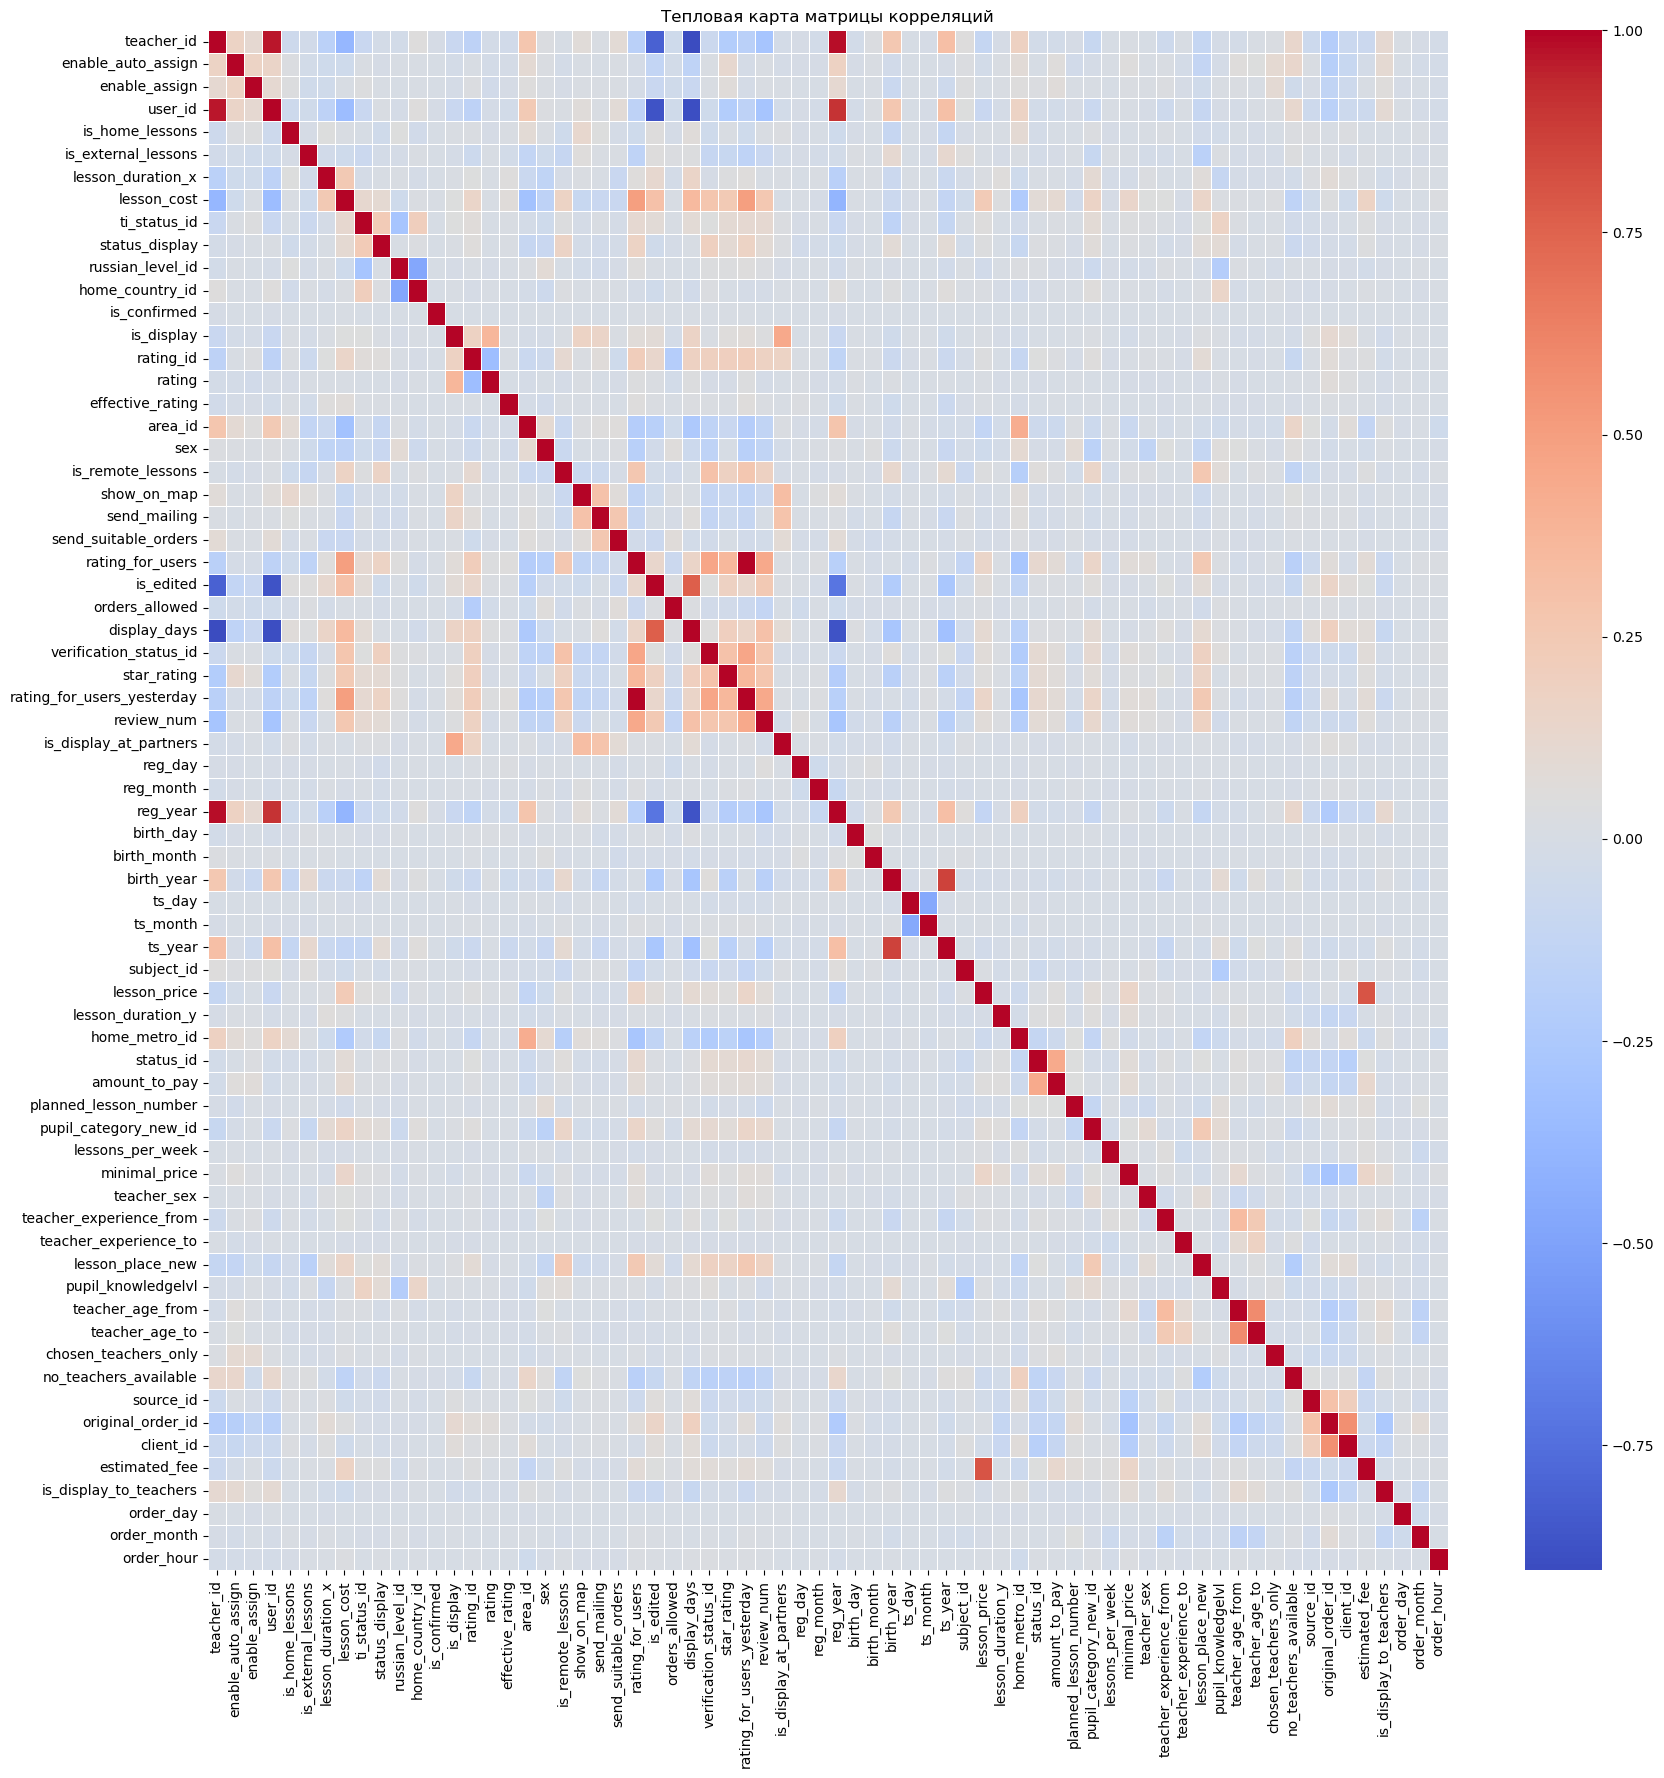

In [181]:
correlation_matrix = final_df.drop(['section', 'pupil_category'], axis = 1).corr()

# Построение тепловой карты
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Тепловая карта матрицы корреляций')
plt.show()

In [182]:
# удалим столбцы с высокой корреляцией и столбцы с ИД
droplist3 = ['teacher_id', 'user_id', 'original_order_id', 'estimated_fee', 'rating_for_users_yesterday', \
             'enable_assign', 'enable_auto_assign', 'is_edited', 'display_days', 'ts_year']
final_df.drop(droplist3, axis = 1, inplace = True)

### Разбиваем данные на тренировочную и тестовую выборки.

In [233]:
features = final_df.drop(['status_id'], axis = 1)
target = final_df['status_id']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.3, \
                                                                           random_state = STATE, stratify = target)

### Кодирование

In [234]:
cat_features = ['section', 'pupil_category']

target_encoder = ce.TargetEncoder(cols=cat_features)
features_train[cat_features] = features_train[cat_features].astype(str)
features_test[cat_features] = features_test[cat_features].astype(str)

features_train[cat_features] = target_encoder.fit_transform(features_train[cat_features], target_train)
features_test[cat_features] = target_encoder.transform(features_test[cat_features])

In [235]:
# не влияет на результат
# smote = SMOTE(random_state = STATE)
# features_train, target_train = smote.fit_resample(features_train, target_train)
# print(features_train.shape, target_train.shape)

### Масштабирование

In [236]:
scaler = StandardScaler()

# исключаем бинарные признаки
columns_to_exclude = ['is_home_lessons', 'is_external_lessons', 'status_display', 'is_confirmed',\
                     'is_display', 'is_remote_lessons', 'show_on_map', 'send_mailing', 'send_suitable_orders', \
                     'orders_allowed', 'is_display_at_partners', 'chosen_teachers_only', 'no_teachers_available',\
                      'is_display_to_teachers']

features_train_to_scale = features_train.drop(columns=columns_to_exclude)
features_test_to_scale = features_test.drop(columns=columns_to_exclude)

scaled_features_train = scaler.fit_transform(features_train_to_scale)
scaled_features_test = scaler.transform(features_test_to_scale)

features_train_scaled = features_train.copy()
features_train_scaled[features_train_to_scale.columns] = scaled_features_train

features_test_scaled = features_test.copy()
features_test_scaled[features_test_to_scale.columns] = scaled_features_test

### Отбор признаков

Обучим логистическую регрессию на кросс-валидации с помощью GenericUnivariateSelect. Отберём 20 самых значимых фичей, которые передадим на вход основной модели.

In [237]:
selector = GenericUnivariateSelect(mode='k_best', param=20)
logistic_regression = LogisticRegression(penalty = 'l1', solver='liblinear')

pipeline = make_pipeline(selector, logistic_regression)
pipeline.fit(features_train_scaled, target_train)

num_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=STATE)
roc_scorer = make_scorer(roc_auc_score)

cv_results = cross_validate(pipeline, features_train_scaled, target_train, cv=num_folds, scoring=roc_scorer, return_estimator=True)
best_model_index = cv_results['test_score'].argmax()
best_model = cv_results['estimator'][best_model_index]
best_model.fit(features_train_scaled, target_train)
best_model_score = f1_score(target_test, best_model.predict(features_test_scaled))
print("Best model ROC_AUC score on test set:", best_model_score)

Best model ROC_AUC score on test set: 0.5868097521920876


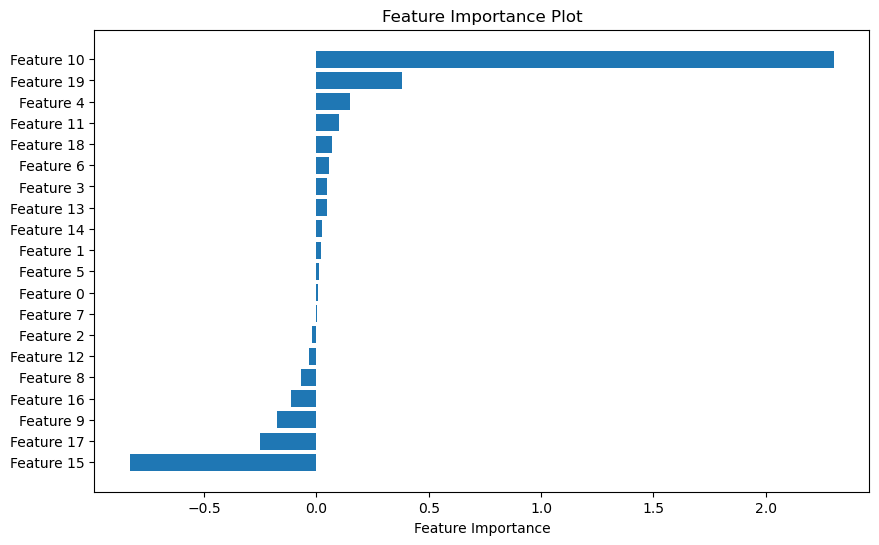

In [238]:
feature_importance = pipeline.named_steps['logisticregression'].coef_[0]
sorted_indices = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), feature_importance[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [f'Feature {i}' for i in sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

In [239]:
# получаем имена фичей
selected_features_mask = selector.get_support()
original_feature_names = features.columns
selected_feature_names = [original_feature_names[i] for i, is_selected in enumerate(selected_features_mask) if is_selected]
selected_feature_names

['lesson_cost',
 'rating_id',
 'area_id',
 'is_remote_lessons',
 'rating_for_users',
 'verification_status_id',
 'star_rating',
 'review_num',
 'subject_id',
 'home_metro_id',
 'amount_to_pay',
 'planned_lesson_number',
 'minimal_price',
 'lesson_place_new',
 'teacher_age_from',
 'no_teachers_available',
 'source_id',
 'client_id',
 'section',
 'pupil_category']

In [240]:
# обрезаем фичи в трейне и тесте
selected_features_train = features_train_scaled[selected_feature_names]
selected_features_test = features_test_scaled[selected_feature_names]
print(selected_features_train.shape, selected_features_test.shape)

(583290, 20) (249982, 20)


In [187]:
# params = {
#     "num_iterations": optuna.distributions.IntDistribution(500, 1000),
#     "learning_rate": optuna.distributions.FloatDistribution(0.001, 0.1),
#     "max_depth": optuna.distributions.IntDistribution(1, 6),
#     "reg_lambda": optuna.distributions.FloatDistribution(0.1, 10),
#     "min_child_samples": optuna.distributions.IntDistribution(1, 20),
#     "feature_fraction": optuna.distributions.FloatDistribution(0.1, 1),
#     "bagging_fraction": optuna.distributions.FloatDistribution(0.1, 1),
#     "boosting_type": optuna.distributions.CategoricalDistribution(['gbdt', 'dart', 'goss']),
# }

# model_lgbm = LGBMClassifier(verbose = -1)

# opt_search_lgbm = optuna.integration.OptunaSearchCV(model_lgbm, params, cv=5, n_trials=5, \
#                                                     scoring='roc_auc', n_jobs=-1, random_state=STATE)
# opt_search_lgbm.fit(features_train, target_train)

# print('Параметры:', opt_search_lgbm.best_params_)
# opt_lgbm_score = opt_search_lgbm.best_score_
# print('ROC AUC for LightGBM Classifier:', opt_lgbm_score)

In [188]:
# best_lgb = opt_search_lgbm.best_estimator_
# preds = best_lgb.predict(features_test)
# report = classification_report(target_test, preds)
# score = roc_auc_score(target_test, preds)
# print(report)
# print('ROC_AUC: ', score)

In [189]:
# cm_display = ConfusionMatrixDisplay.from_predictions(
#     target_test, preds, display_labels=['1', '0'])

LGBM test 0.73

### Обучение модели и подбор гиперпараметров.

Используем OptunaSearchCV для подбора и кросс-валидации.

In [241]:
params = {
    "iterations": optuna.distributions.IntDistribution(500, 1000),
    "learning_rate": optuna.distributions.FloatDistribution(0.001, 0.1),
    "depth": optuna.distributions.IntDistribution(1, 6),
    "l2_leaf_reg": optuna.distributions.FloatDistribution(0.1, 10),
    "border_count": optuna.distributions.IntDistribution(1, 255),
    "bagging_temperature": optuna.distributions.FloatDistribution(0, 1),
    "random_strength": optuna.distributions.FloatDistribution(0, 1),
    "one_hot_max_size": optuna.distributions.IntDistribution(0, 50),
    "leaf_estimation_iterations": optuna.distributions.IntDistribution(1, 10),
}

model_cbc = CatBoostClassifier(logging_level = 'Silent')
opt_search_cbc = optuna.integration.OptunaSearchCV(model_cbc, params, cv = 5, n_trials = 10, \
                                               scoring = 'roc_auc', n_jobs = -1, random_state = STATE)
opt_search_cbc.fit(selected_features_train, target_train)

print('Параметры:', opt_search_cbc.best_params_)
opt_cbc_score = opt_search_cbc.best_score_
print('roc_auc for CatBoost Classifier', opt_cbc_score)

/var/folders/0v/khfzfvln7tb5k2sbvh23_wv40000gn/T/ipykernel_92818/3254760777.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_search_cbc = optuna.integration.OptunaSearchCV(model_cbc, params, cv = 5, n_trials = 10, \
[I 2024-02-11 22:28:47,273] A new study created in memory with name: no-name-89c74feb-f5c5-41f6-b9df-8937021614cf
[I 2024-02-11 22:31:51,894] Trial 6 finished with value: 0.8248906717844117 and parameters: {'iterations': 536, 'learning_rate': 0.005472675892919027, 'depth': 3, 'l2_leaf_reg': 1.3571393660617255, 'border_count': 13, 'bagging_temperature': 0.589259576640949, 'random_strength': 0.9303774780425964, 'one_hot_max_size': 4, 'leaf_estimation_iterations': 1}. Best is trial 6 with value: 0.8248906717844117.
[I 2024-02-11 22:34:09,561] Trial 2 finished with value: 0.8570095458746353 and parameters: {'iterations': 564, 'learning_rate': 0.04714264268367288, 'depth': 5, 'l2_leaf_reg': 5.90718

Параметры: {'iterations': 645, 'learning_rate': 0.08312245998858586, 'depth': 5, 'l2_leaf_reg': 9.156265218006377, 'border_count': 177, 'bagging_temperature': 0.6104022560174275, 'random_strength': 0.09018921544561243, 'one_hot_max_size': 16, 'leaf_estimation_iterations': 9}
roc_auc for CatBoost Classifier 0.8613537894615932


### Тестирование

In [242]:
best_cbc = opt_search_cbc.best_estimator_
preds = best_cbc.predict(selected_features_test)
report = classification_report(target_test, preds)
score = roc_auc_score(target_test, preds)
print(report)
print('ROC_AUC: ', score)

              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87    165435
         1.0       0.84      0.53      0.65     84547

    accuracy                           0.81    249982
   macro avg       0.82      0.74      0.76    249982
weighted avg       0.81      0.81      0.79    249982

ROC_AUC:  0.7407273135224606


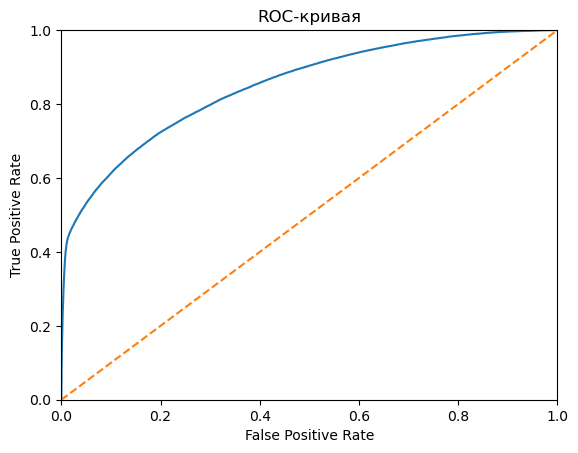

In [298]:
probabilities = best_cbc.predict_proba(selected_features_test)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)

plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show();

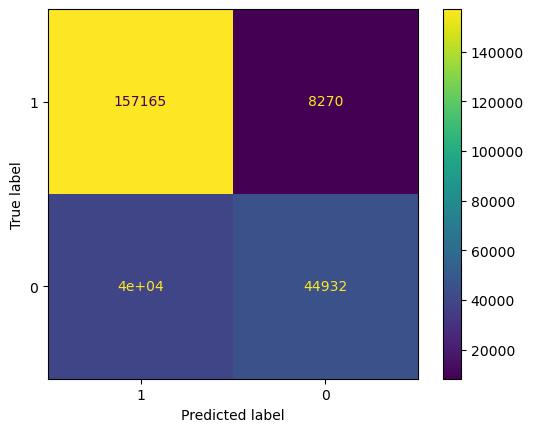

In [271]:
cm_display = ConfusionMatrixDisplay.from_predictions(
    target_test, preds, display_labels=['1', '0'])

### Важность признаков

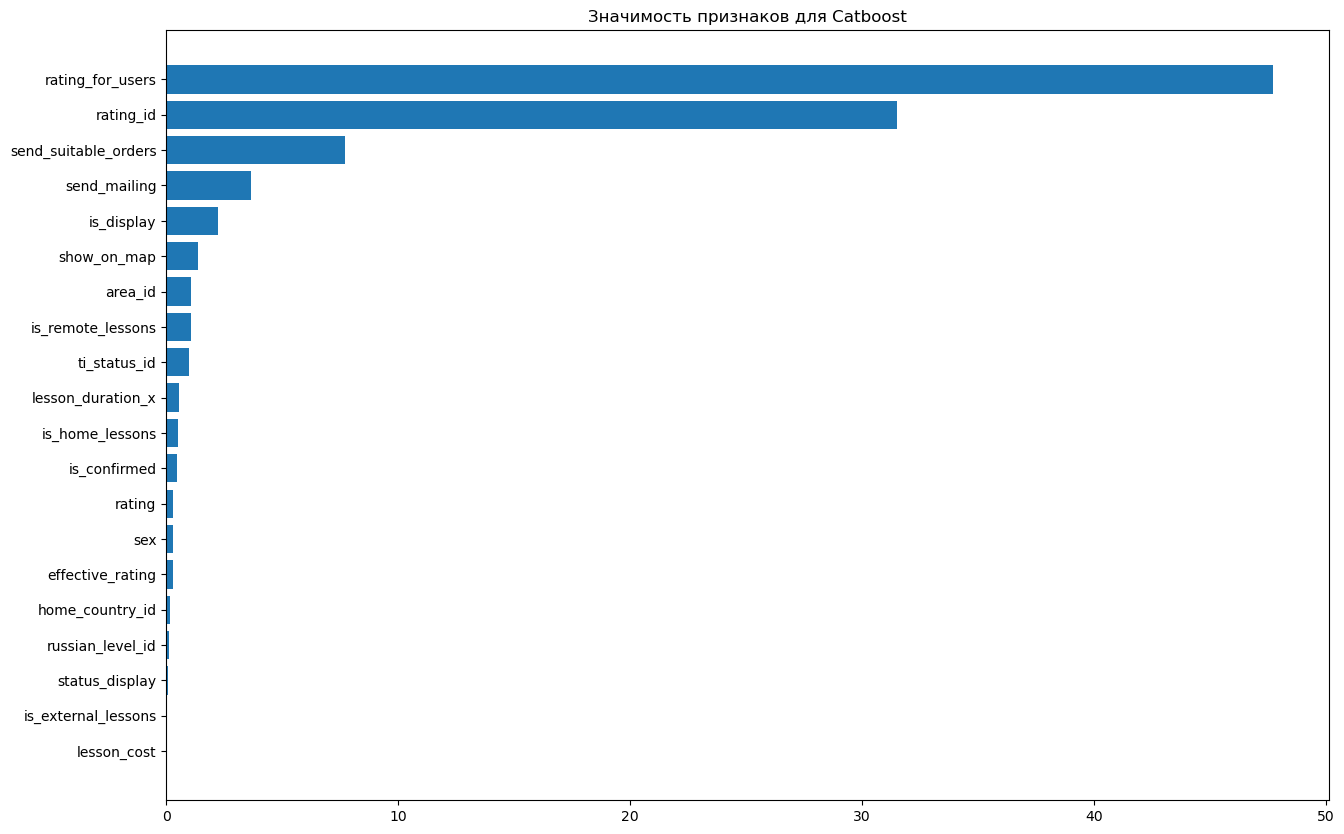

In [270]:
feature_importance = best_cbc.feature_importances_
sorted_indicies = np.argsort(feature_importance)

fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_indicies)), feature_importance[sorted_indicies], align='center')
plt.yticks(range(len(sorted_indicies)), np.array(features.columns)[sorted_indicies])
plt.title('Значимость признаков для Catboost');

In [258]:
# почему-то калибратор не может работать с best_cbc, не видит модель
# calibrated_model = CalibratedClassifierCV(base_estimator=best_cbc, method='sigmoid', cv='prefit')
# calibrated_model.fit(selected_features_train, target_train)
# probabilities = calibrated_model.predict_proba(selected_features_test)

In [300]:
# best_cbc

### Сохраняем результат

In [299]:
features_test_with_preds = features_test.copy()
features_test_with_preds['predictions'] = probabilities_one
features_test_with_preds

,is_home_lessons,is_external_lessons,lesson_duration_x,lesson_cost,ti_status_id,status_display,russian_level_id,home_country_id,is_confirmed,is_display,rating_id,rating,effective_rating,area_id,sex,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,orders_allowed,verification_status_id,star_rating,review_num,is_display_at_partners,reg_day,reg_month,reg_year,birth_day,birth_month,birth_year,ts_day,ts_month,subject_id,lesson_price,lesson_duration_y,home_metro_id,amount_to_pay,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,client_id,is_display_to_teachers,order_day,order_month,order_hour,section,pupil_category,predictions
256016,1.0,1.0,90.0,2500.0,5.0,1.0,5.0,7.0,1.0,1.0,17.0,7.0,11.945312,1.0,2.0,1.0,1.0,0.0,0.0,4824.0,1.0,3.0,5.000000,16.0,1.0,11.0,9.0,2010.0,29.0,5.0,1989.0,1.0,9.0,14.0,2500.0,60.0,185.0,0.0,10.0,12.0,4.0,0.0,3.0,5.0,0.0,2.0,0.0,30.0,60.0,0.0,0.0,23.0,981769.0,1.0,3.0,9.0,18.0,0.292828,0.298424,0.336522
62025,0.0,1.0,60.0,2500.0,5.0,1.0,5.0,7.0,1.0,1.0,17.0,7.0,-0.445312,1.0,2.0,1.0,1.0,1.0,1.0,2700.0,1.0,3.0,4.898438,43.0,1.0,16.0,3.0,2010.0,21.0,1.0,1962.0,1.0,9.0,21.0,4000.0,60.0,0.0,1000.0,1.0,15.0,2.0,2000.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,16.0,865867.0,1.0,3.0,11.0,16.0,0.206587,0.324875,0.035442
502406,1.0,1.0,60.0,1000.0,4.0,0.0,5.0,7.0,1.0,1.0,16.0,6.0,9.000000,2.0,1.0,1.0,1.0,1.0,1.0,192.0,1.0,1.0,5.000000,2.0,1.0,22.0,9.0,2013.0,23.0,9.0,1973.0,1.0,9.0,8.0,2000.0,60.0,297.0,0.0,10.0,9.0,5.0,0.0,3.0,10.0,0.0,2.0,0.0,25.0,50.0,0.0,0.0,23.0,414833.0,1.0,26.0,3.0,21.0,0.292828,0.279105,0.290986
365493,0.0,1.0,60.0,0.0,5.0,1.0,5.0,7.0,1.0,1.0,15.0,5.0,0.000000,40.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4.300781,0.0,1.0,16.0,1.0,2019.0,2.0,2.0,1981.0,1.0,9.0,8.0,900.0,60.0,1423.0,1350.0,10.0,6.0,3.0,0.0,3.0,10.0,0.0,1.0,0.0,30.0,90.0,0.0,0.0,23.0,1043156.0,1.0,30.0,11.0,15.0,0.292828,0.286528,0.928652
77043,1.0,1.0,60.0,1000.0,5.0,1.0,5.0,7.0,1.0,1.0,15.0,5.0,0.000000,1.0,1.0,1.0,0.0,0.0,1.0,402.5,1.0,0.0,5.000000,5.0,1.0,9.0,9.0,2018.0,28.0,3.0,1986.0,1.0,9.0,21.0,1200.0,60.0,225.0,0.0,10.0,7.0,4.0,1000.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,873674.0,1.0,24.0,11.0,11.0,0.101913,0.367327,0.094075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409069,1.0,1.0,60.0,0.0,1.0,1.0,5.0,7.0,1.0,1.0,15.0,5.0,0.000000,35.0,2.0,0.0,0.0,0.0,1.0,150.0,1.0,0.0,4.300781,0.0,1.0,1.0,11.0,2021.0,11.0,3.0,1997.0,1.0,9.0,2.0,500.0,60.0,1305.0,0.0,10.0,9.0,3.0,0.0,3.0,0.0,0.0,3.0,3.0,16.0,0.0,0.0,1.0,23.0,1073359.0,1.0,18.0,1.0,1.0,0.292828,0.279105,0.036484
119378,0.0,0.0,60.0,900.0,5.0,1.0,5.0,7.0,1.0,1.0,17.0,7.0,0.000000,1.0,2.0,1.0,0.0,1.0,1.0,3930.0,1.0,3.0,5.000000,14.0,1.0,16.0,9.0,2020.0,10.0,8.0,1996.0,1.0,9.0,2.0,500.0,60.0,0.0,0.0,10.0,5.0,4.0,400.0,2.0,2.0,0.0,4.0,0.0,25.0,45.0,0.0,0.0,14.0,563595.0,1.0,25.0,1.0,18.0,0.394385,0.319142,0.447967
231962,0.0,0.0,60.0,1000.0,3.0,0.0,5.0,7.0,1.0,1.0,16.0,6.0,8.828125,1.0,2.0,1.0,1.0,1.0,1.0,5248.0,1.0,1.0,5.000000,3.0,1.0,30.0,8.0,2012.0,3.0,1.0,1985.0,1.0,9.0,18.0,2000.0,60.0,180.0,5250.0,10.0,4.0,7.0,1000.0,2.0,0.0,0.0,3.0,0.0,26.0,0.0,0.0,0.0,17.0,772797.0,1.0,7.0,8.0,14.0,0.311202,0.336701,0.978083
488144,1.0,1.0,90.0,1200.0,5.0,1.0,5.0,7.0,1.0,1.0,15.0,5.0,0.000000,1.0,2.0,0.0,1.0,1.0,1.0,48.0,1.0,0.0,3.599609,2.0,1.0,15.0,4.0,2016.0,31.0,10.0,1974.0,1.0,9.0,18.0,1500.0,60.0,241.0,0.0,10.0,3.0,5.0,0.0,2.0,10.0,0.0,1.0,0.0,25.0,50.0,0.0,0.0,14.0,1114510.0,1.0,15.0,3.0,10.0,0.295398,0.276790,0.159126


In [302]:
features_test_with_preds.to_csv('Заявки с вероятностью оплаты')

## Вывод:

Были проанализированы данные по таблицам заявок для сервиса по подбору репетиторов.

В таблице **```orders```** были удалены неинформативные столбцы:

Были удалены неинформативные столбцы:
- ```id``` - идентификатор
- ```lesson_place``` - слишком много пропусков
- ```comments``` - комментарии операторов нам не нужны
- ```prefered_teacher_id``` - слишком много пропусков
- ```creator_id``` - идентификатор создателя заявки будет неинформативным признаком
- ```additional_status_id``` - не совсем понятно, что это за данные
- ```max_metro_distance``` - слишком много пропусков
- ```estimated_fee``` - слишком много пропусков
- ```payment_date``` - будет неинформативным признаком, т.к. у нас уже есть ключевой столбец со статусом заявки
- ```start_date``` - будет неинформативным признаком, т.к. у нас уже есть ключевой столбец со статусом заявки + тут очень много пропусков в этом столбце
- ```working_teacher_id``` - много пропусков
- ```first_lesson_date``` - так же много пропусков
-------------------------------------------------------------
Обработаны пропуски и аномалии:

- Удалены 4 аномальных записи, где subject_id был во всех полях
- Удалены аномалии в ```lesson_price``` с высокой стоимостью
- Обработан столбец с целевым признаком ```status_id```: значения 5, 6, 13, 15 заменены на 1, остальные на 0.
- ```amount_to_pay``` определён характер выбросов, они относятся к оплаченным заявкам, данные решено оставить
- ```minimal_price``` - удалены выбросы с показателем > 20000, т.к. они относятся к неоплаченным заявкам
- ```teacher_sex``` - объеденины 2 категории «не имеет значения» и «значение не указано»
- Желаемый опыт от/до ```teacher_experience_from/to``` - устранены аномальные значения, заменены на 0
- Желаемый возраст репетитора от/до ```teacher_age_from/to``` - устранены аномальные значения, заменены на 0

В таблице **```teachers_info```**:

- удалены дубликаты столбцов и столбцы с пропусками
- столбцы с датами приведены к соответстующему типу
- удалены следующие признаки, как неинформативные (почти все значения были либо 1 либо 0): ```is_email_confirmed```, ```is_cell_phone_confirmed```, ```amount_to_pay```
- обработаны выбросы в столбце с продолжительностью занятия и стоимостью

**Обработаны дубли заявок**

В группах заявок с одинаковым ```original_order_id``` поле ```status_id``` заменено на 1, если хотя бы у одной заявки в группе есть статус 1.

Дополнительно, проверены группы заявок по ИД клиентов. Если клиент оплатил более 7 заявок, то он постоянный и все заявки от этого клиента помечены как оплаченные.

На этапе **создания признаков** из ```df_orders['purpose']``` сгенерированы категориальные признаки. Из таблицы ```teachers_info``` взяты даты и сгенерированы отдельные признаки по дню/месяцу/году.

- Данные были объеденены в один датафрейм. 
- Выполнена проверка на мультиколлинеарность, удалены признаки с высокой корреляцией.
- Для кодирования категориальных признаков использовался ```target_encoder```. 
- Все числовые признаки (кроме бинарных) были отмасштабированы при помощи ```StandardScaler```.
- Для отбора признаков использовалась логистическая регрессия на кросс-валидации с помощью ```GenericUnivariateSelect```. 
- Были отобраны 20 признаков, которые передаются на вход основной модели.
- В качестве основной модели был использован ```CatBoost Classifier```
- Для подбора гиперпараметров и кросс-валидации ```OptunaSearchCV```

По результатам **тестирования** удалось достичь значения целевой метрики ```ROC_AUC``` 0.74 и ```precision``` для первого класса 0.84.
- Выведен график ROC_AUC
- Выведена матрица ошибок
- Выведен график важности признаков
- Получены вероятности предсказаний
- Вероятности добавлены к тестовой части и сохранены в csv-файл